# Can We Predict the Weather Accurately Using Neural Networks?


<b><u>Abstract:</u></b><br>
Predicting the weather has been of importance to humans for thousands of years; it dictates how we make a multitude of decisions, varying from choosing what to wear in the morning to knowing when is a good time to plant crops. Currently, our weather predictions lie in the hands of meteorologists who use complicated models and algorithms based on concepts from physics, chemistry and mathematics in order to make their predictions. While the quality of these predictions has steadily improved over the years, the mathematically chaotic nature that weather patterns tend to follow make predictions extremely difficult, especially over long periods of time. Improving the accuracy of these predictions using machine learning models could be the next step towards advanced weather predictions. The work presented here shows that by using a model consisting of a combination of different nerual networks, reasonable predictions can be made. The quality of these predictions is perhaps hinting at the possibility of more accuracte models that could be developed in the near future. 

<table>
    <tr>
        <td>
            <figure>
                <img width="300" height="300" src="images/neural_network_brain.png">
            </figure>
        </td>
        <td>
            <figure>     
                <img src="images/weather_forcast.jpg">
           </figure>
        </td>
    </tr>
</table>



## Section 0: Imports, Functions, and Global Variables
As its name suggests, this section contains all of the imports, functions, and global variable declations that are used in order to complete this project. All of these items were included here to enhance readability of later sections and provide a single place where they can be referenced, if necessary. 

### 0.1: Imports
Below is a list of all imports that were used in order to complete this project, organized by category. 

In [1]:
# Data manipulation imports
import pandas as pd
import numpy as np
np.random.seed(91993) 

In [2]:
# Plotting imports 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# Mathematical tools imports
import math
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.integrate import odeint

In [4]:
# Data Preprocessing Imports
from sklearn.decomposition import PCA
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [5]:
# Machine Learning Algorithm Imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

In [6]:
# Model selection (hyperparameter tuning) imports
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [7]:
# Neural Network Imports (Keras and tensorflow)
import keras
from keras import backend as K
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.metrics import categorical_accuracy
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

### 0.2: Functions
Below is a list of all functions that were used in order to complete this project, listed in the order in which they are first used. Note that some funcitons are declared later in the notebook if they pertain only to a certain section.

In [8]:
def make_classes(rainfall, snowfall):
    '''Creates target variable to predict by generating the following three classes from 
    rainfall and snowfall measurements:
    
    0 --> Clear weather, no rain or snow.
    1 --> Rainy weather.
    2 --> Snowy weather. 
    '''
    if snowfall == 0:
        if rainfall == 0:
            return 0
        else:
            return 1
    else:
        return 2
    
def prepare_data(df, num_hours, do_std_scaler=False, do_min_max_scaler=False, do_pca=-1, do_smote=False):
    '''Prepares data analysis by various machine leanring algorithms or neural networks. Returns
    training, validation and testing sets for both the predictor and target variables. A description of 
    each argument is given below:
    
    df --> The dataframe containing the data. 
    
    num_hours --> The value in the num_hours column used to filter out the desired data. 
    
    do_std_scaler --> If True, creates an instance of the StandardScaler class, fits it to the 
    X training data, and then transforms the X training, validation, and testing sets. 
    
    do_min_max_scaler --> If True, creates an instance of the MinMaxScaler class, fits it to the 
    X training data, and then transforms the X training, validation, and testing sets.
    
    do_PCA --> If 0, creates an instance of the PCA class with no set value for the n_components
    of the PCA class. If > 0, creates an instance of the PCA class with n_components = do_pca. In both cases,
    the function fits it to the X training data, and then transforms the X training, validation, and testing sets. 
    
    do_SMOTE --> If True, creates an instance of the SMOTE class, fits it to the X and y training data, 
    and resamples both training sets. 
    
    X_test and y_test are created using the df_test dataset created in Section 2. 
    '''
    y = df[df['num_hours']==num_hours]['class'].values
    X = df[df['num_hours']==num_hours].drop(columns=cols_to_drop).values
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
    X_test = df_test[df_test['num_hours']==num_hours].drop(columns=cols_to_drop).values
    y_test = df_test[df_test['num_hours']==num_hours]['class'].values
    
    if do_std_scaler == True:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)
    if do_min_max_scaler == True:
        scaler = MinMaxScaler(feature_range=(0,1))
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)
    if do_pca > -1:
        if do_pca == 0:
            pca = PCA()
        elif do_pca > 0:
            pca = PCA(n_components = do_pca)
        X_train = pca.fit_transform(X_train)
        X_val = pca.transform(X_val)
        X_test = pca.transform(X_test)
    if do_smote == True:
        sm = SMOTE(random_state=rs)
        X_train, y_train = sm.fit_sample(X_train, y_train)
        
    
    return X_train, X_val, X_test, y_train, y_val, y_test
    
def give_metrics(y_true, y_pred, num_classes, variables=False):
    '''Given a set of predictions and true values, determine and print the accuracy, precision, and recall
    for each class. In addition, give_metrics() prints the confusion matrix, total accuracy, 
    macro averaged precision, macro averaged recall, and macro averaged F1 score.
    '''
    assert(num_classes > 0), 'Number of classes cannot be 0 or less!'
    assert (len(y_true) == len(y_pred)), "Array length does not match!"
    
    con_mat = confusion_matrix(y_true, y_pred)
    TP = np.diag(con_mat)
    FP = con_mat.sum(axis=0) - np.diag(con_mat)  
    FN = con_mat.sum(axis=1) - np.diag(con_mat)
    TN = con_mat.sum() - (FP + FN + TP)
    
    recalls = TP/(TP+FN)
    precisions = TP/(TP+FP)
    F1_scores = 2 * ((recalls*precisions)/(precisions+recalls))
    acc = np.sum(TP)/len(y_true)

#   recall_micro_avg = np.sum(TP) / (np.sum(TP) + np.sum(FN))
    recall_macro_avg = np.sum(recalls) / num_classes
#   precision_micro_avg = np.sum(TP) / (np.sum(TP) + np.sum(FP))
    precision_macro_avg = np.sum(precisions) / num_classes
    F1_macro_avg = 2 * ((recall_macro_avg*precision_macro_avg)/(precision_macro_avg+recall_macro_avg))
    
    if variables == True:
        return acc, recall_macro_avg, precision_macro_avg, F1_macro_avg
    
    print('Performance Metrics: \n')
    print('Confusion Matrix:')
    print(con_mat)
    print('\n')

    for i in range(num_classes):
        print('Class %d:' %i)
        print('Recall: ', recalls[i])
        print('Precision: ', precisions[i])
        print('F1 Score:', F1_scores[i])
        print('\n')

    print('Overall Metrics:')
    print('Total Accuracy: ', acc)
    print('Average Recall (Macro): ', recall_macro_avg)
#   print('Average Recall (Micro): ', recall_micro_avg)
#   print('\n')
    print('Average Precision (Macro) :', precision_macro_avg)
    print('Average F1 Score (Macro): ', F1_macro_avg)
#   print('Average Precision (Micro) :', precision_micro_avg)
    
def give_class_names(class_num):
    '''Given the class number, return the name of the class.'''
    if class_num == 0:
        return 'Clear'
    elif class_num == 1:
        return 'Rain'
    else:
        return 'Snow'
    
def make_weather_prediction(measurements):
    '''Given a set of initial weather conditions, make a prediction as to whether it will
    rain, snow or be clean from 0-12 hours into the future. Each prediction is made using a 
    tuned neural network.
    '''
    prediction_0hr = np.argmax(model_0hr.predict(X_scaler_0hr.transform(measurements)), axis = 1)
    prediction_1hr = np.argmax(model_1hr.predict(X_scaler_1hr.transform(measurements)), axis = 1)
    prediction_2hr = np.argmax(model_2hr.predict(X_scaler_2hr.transform(measurements)), axis = 1)
    prediction_3hr = np.argmax(model_3hr.predict(X_scaler_3hr.transform(measurements)), axis = 1)
    prediction_4hr = np.argmax(model_4hr.predict(X_scaler_4hr.transform(measurements)), axis = 1)
    prediction_5hr = np.argmax(model_5hr.predict(X_scaler_5hr.transform(measurements)), axis = 1)
    prediction_6hr = np.argmax(model_6hr.predict(X_scaler_6hr.transform(measurements)), axis = 1)
    prediction_7hr = np.argmax(model_7hr.predict(X_scaler_7hr.transform(measurements)), axis = 1)
    prediction_8hr = np.argmax(model_8hr.predict(X_scaler_8hr.transform(measurements)), axis = 1)
    prediction_9hr = np.argmax(model_9hr.predict(X_scaler_9hr.transform(measurements)), axis = 1)
    prediction_10hr = np.argmax(model_10hr.predict(X_scaler_10hr.transform(measurements)), axis = 1)
    prediction_11hr = np.argmax(model_11hr.predict(X_scaler_11hr.transform(measurements)), axis = 1)
    prediction_12hr = np.argmax(model_12hr.predict(X_scaler_12hr.transform(measurements)), axis = 1)
    predictions = [prediction_0hr, prediction_1hr, prediction_2hr, prediction_3hr, \
                   prediction_4hr, prediction_5hr, prediction_6hr, prediction_7hr, \
                   prediction_8hr, prediction_9hr, prediction_10hr, prediction_11hr, \
                   prediction_12hr]
    predictions = pd.DataFrame({'predictions': predictions})
    predictions = predictions['predictions'].map(give_class_names)
    return predictions

### 0.3: Global Variables 
The cell below contains all global variables that were used in this project, in order to increase ease of reproducability. 

In [9]:
rs = 42 # The random_state used by all relevant functions and methods in this project. 
seed_num = 91993 # The seed number for random calculations carried out by the numpy package. 
np.random.seed(seed_num) 

## Section 1: Introduction
This sections contains all introductory material that is referenced in later sections of this project. 
### 1.1: How are Weather Predictions Made?
Weather predictions are something that all of us rely on every day. In fact, the first thing most people do before heading out the door is check their favorite weather app to determine what they should be wearing that day. While we are surrounded by weather predictions every day, it turns out that the models used to calculate these predictions are extemeley complex. While there are a multitude of different methods for doing this, they almost always rely on some implementation of the Navier-Stokes equations. These equations are the foundation of fluid dynamics, similar to how the Schrodinger equation is the foundation of quantum mechanics. While these equaitons are a great achievement of physics, the fact that they are intricate differential equations makes them difficult to solve. One version of the equations can be seen below, provided by NASA: 

<img width="700" height="700" src="images/navier_stokes_equations.gif"/>

While the equations do provide information about the temperature, pressure, momentum, and density of a moving fluid, there is a lot of computational work that needs to be done in order to solve them. <br>

In addition to the complex nature of the Navier Stokes equations, another complication inherent to predicting weather patterns is that they are considered to be chaotic systems. Mathematically speaking, chaotic systems exhibit the following traits:

<ol>
    <li> The system is deterministic.</li>
    <li> The system is aperiodic.</li>
    <li> The system is extremely sensitive to intitial conditions.</li>
</ol>
        
The first trait might not make sense at first, as it might seem that a chaotic system is one that shouldn't be able to be perfectly described (deterministic). However, this is a common misconception: chaotic systems are entirely predictable - even for long periods of time - if you have the correct inputs. The real difficulty in modeling chaotic systems results from the third trait: chaotic systems are extremeley sensitive to initial conditions, meaning that two slightly different sets of inputs can result is drastically different predictions. In other words, no matter how close a meterologist is to getting spot on atmospheric data, even the smallest discrepensy from the actual values can cause predictions to be way off in the near future. This is sometimes more colloquially referred to as the "butterfly effect." The following aside gives an example of a more simplistic chaotic system. 

### Aside: A Simple Chaotic System - The Lorenz System
One of the very first systems that is studied in any chaos theory class in known as the Lorenz system, first brought to light by the mathematician Edward Lorenz. This system relates to the project presented here, as he studied it in an attempt to better understand atmospheric convection. The system consists of three ordinary differential equations, which are shown below:

$$
\begin{align}
\frac{dx}{dt} &= \sigma(y-x) \\
\frac{dy}{dt} &= x(\rho-z)-x \\
\frac{dz}{dt} &= xy - \beta z
\end{align}
$$

In the equations above, $x$, $y$, and $z$ are cartesian coordinates, while $\sigma$, $\rho$, and $\beta$ are system parameters. This system is translated into python in the cell below:

In [10]:
def dx_dt(x, y):
    return sigma * (y - x)
def dy_dt(x, z):
    return x * (rho - z) - x
def dz_dt(x, y, z):
    return x * y - beta * z
def lorenz_system(coordinates, t):
    x, y, z = coordinates
    return dx_dt(x, y), dy_dt(x, z), dz_dt(x, y, z) 

It turns out that for most values of $\sigma$, $\rho$, and $\beta$, the Lorenz system is not chaotic at all. More specifically, if $\rho$ is small, the system almost always converges to one or two fixed points. However, once $\rho$ is larger than $\approx$ 24.74, chaotic behavior starts to occur. Feel free to change the intial conditions ($\sigma$, $\rho$, and $\beta$) in the cell below in order to see how the behavior of the lorenz system changes. Some suggestions are given below:

<ul>
    <li>$\rho$=10, $\sigma$=10, $\beta=\frac{8}{3}$: To see how the lorenz system behaves when it is not chaotic.</li>
    <li>$\rho$=28, $\sigma$=10, $\beta=\frac{8}{3}$: To see how the lorenz system behaves when it is not chaotic.</li>
    <li>$\rho$=28.1, $\sigma$=10, $\beta=\frac{8}{3}$: To see how a small change to a chaotic system produces an entirely different result.</li>
</ul>

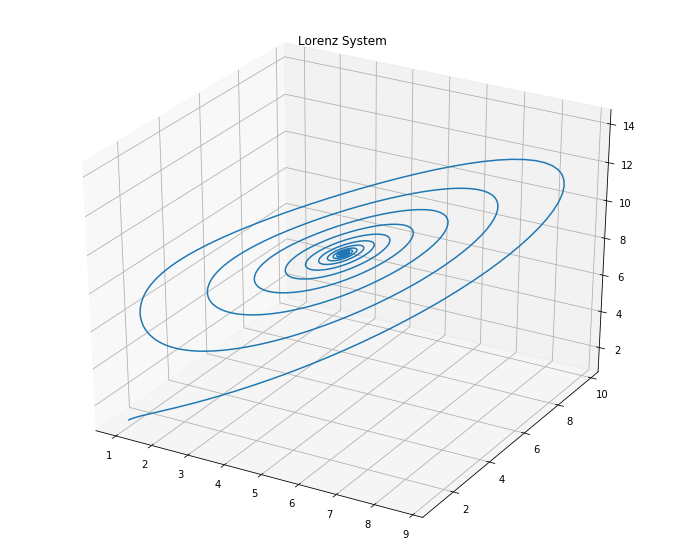

In [11]:
# Try changing these three variables
rho = 10.0
sigma = 10.0
beta = 8.0 / 3.0

# Do not change these...
t_i = 0
t_f = 20
t_step = 0.01
t = np.arange(t_i, t_f, t_step)
initial_xyz = [1.0, 1.0, 1.0]

def plot_lorenz(initial_xyz, t):
    positions = odeint(lorenz_system, initial_xyz, t)
    plt.axes(projection='3d')
    plt.title('Lorenz System')
    plt.plot(positions[:,0], positions[:,1], positions[:,2])
    
plt.figure(figsize=(12,10))
plot_lorenz(initial_xyz, t)

In case its too hard to make out the difference, the cell below shows the Lorenz system when $\rho$=28.0, $\sigma$=10.0, $\beta=\frac{8}{3}$, and when $\rho$=28.1, $\sigma$=10.0, $\beta=\frac{8}{3}$.

<table>
    <tr>
        <td>
            <figure>
                <img src="images/lorenz1.png">
                <figcaption><center>Initial Conditions: $\rho$=28.0, $\sigma$=10.0, and $\beta=\frac{8}{3}$.</center></figcaption>   
            </figure>
        </td>
        <td>
            <figure>     
                <img src="images/lorenz2.png">
                <figcaption><center>Initial Conditions: $\rho$=28.1, $\sigma$=10.0, and $\beta=\frac{8}{3}$.</center></figcaption>
           </figure>
        </td>
    </tr>
</table>


While the general shape of the graph is the same, further inspection reveals many differences by simply shifting $\rho$ by only 0.1 Another way of looking at this is to examine the final points of the lorenz system using each set of initial conditions. This is done in the cell below: 

In [12]:
rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0
positions1 = odeint(lorenz_system, initial_xyz, t)
rho = 28.1
sigma = 10.0
beta = 8.0 / 3.0
positions2 = odeint(lorenz_system, initial_xyz, t)
print('Last Positions of Lorenz system with rho = 28.0: ', positions1[-1])
print('Last Positions of Lorenz system with rho = 28.1: ', positions2[-1])

Last Positions of Lorenz system with rho = 28.0:  [ 4.03961787  3.69586463 22.21668626]
Last Positions of Lorenz system with rho = 28.1:  [-8.60326073 -4.65002045 31.52552305]


We see that the final points from each system are completely different despite their initial conditions being nearly identical. Lastly, we can look at the mean squared error between the points from the two different Lorenz systems that were calculated:

In [13]:
print('Mean Squared Error between the two lorenz systems:', mean_squared_error(positions1, positions2))

Mean Squared Error between the two lorenz systems: 82.00549649230874


As is clear from the printout above, despite their shape looking similar, the points from the two different systems have an exorbitantly high mean squared error.

The purpose in showing this example is to demonstrate that this sensitivity to inital conditions for chaotic systems can make the task of producing accurate weather predictions extremely difficult. The systems that dictate our weather patterns are also much more complex than the lorenz system, further adding to the issue. In summary, this means that if the atmospheric data used to make predictions is only slightly different from the actual value, the predictions might not be close to the weather that's actually on its way. This sensitivity also gets worse over time, which accounts for the fact that weather predictions made far in advance have a high probability of being incorrect. 

### 1.2: Neural Networks, a Possible Solution?

The previous subsection described how the current methods that are used in making weather predictions exhibit a number of serious flaws. The work performed here is meant to test whether or not predictive algorithms (specifically, neural networks) can be used to make predictions that are as accurate, or possibly even more so than the physical models that are currently in use. <br><br>

Nueral networks seemed like a reliable choice to attempt to solve this problem, as they are capable of being able to determine complicated linear and non-linear relationships between a large number of input variables. In addition, because the current method of weather forecasting is also complex, there already exists a large amount of high quality atmospheric data being used to make the predictions as accurate as possible. The work done in this project simply applies that same data to different machine learning models, with the most accurate possible neural network as the desired product. In general, these models performed reasonably well. 

### 1.3: The Data
The data used in this project comes from <a href="https://www.meteoblue.com/en/weather/week">meteoblue</a>, a meteorological service created at the University of Basel. They provide current, high quality meteorological data from places all over the world, but also give access to free historical weather data for Basel, Switzerland dating back to 1984. This was the data used for this project, and can be accessed <a href="https://www.meteoblue.com/en/products/historyplus/download/basel_switzerland_2661604">here.</a> A list of all the variables that are included in the dataset, along with their units and a brief description, is listed in the table below:

<table style="width:80%">
  <tr>
    <th>Measurement</th>
    <th>Units</th> 
    <th>Description</th>
  </tr>
  <tr>
    <td>Temperature</td>
    <td>$^{\circ}$F</td> 
    <td>The temperature recorded from 2 meters above the ground.</td>
  </tr>
  <tr>
    <td>Relative humidity</td>
    <td>%</td> 
    <td>the amount of water vapor present in air expressed as a percentage of the amount needed for saturation at the same temperature</td>
  </tr>
  <tr>
    <td>Pressure</td>
    <td>hPa</td> 
    <td>The mean sea level pressure (MSLP).</td>
  </tr>
  <tr>
    <td>Precipitation Amount</td>
    <td>mm</td> 
    <td>The total amount of precipitation that fell in hour measured according to a high resolution model.</td>
  </tr>
  <tr>
    <td>Precipitation amount (low resolution)</td>
    <td>mm</td> 
    <td>The total amount of precipitation that fell in hour measured according to a low resolution model.</td>
  </tr>
  <tr>
    <td>Snowfall amount (high resolution)</td>
    <td>cm</td> 
    <td>The total amount of snowdall that fell in the hour measured according to a high resolution model.</td>
  </tr>
  <tr>
    <td>Snowfall amount (low resolution)</td>
    <td>cm</td> 
    <td>The total amount of precipitation that fell in the hour measured according to a low resolution model.</td>
  </tr>
  <tr>
    <td>Total cloud cover</td>
    <td>%</td> 
    <td>The fraction of the sky covered by a cloud of any type at any height in the sky.</td>
  </tr>
  <tr>
    <td>High cloud cover</td>
    <td>%</td> 
    <td>The fraction of the sky covered by clouds at high elevation (5-13 km).</td>
  </tr>
  <tr>
    <td>Mid cloud cover</td>
    <td>%</td> 
    <td>The fraction of the sky covered by clouds at medium elevation (2-7 km).</td>
  </tr>
  <tr>
    <td>Low cloud cover</td>
    <td>%</td> 
    <td>The fraction of the sky covered by clouds at low elevation ($<$2 km).</td>
  </tr>
  <tr>
    <td>Sunshine duration (minutes)</td>
    <td>Minutes</td> 
    <td>The number of minutes in each hour when there was no cloud cover.</td>
  </tr>
  <tr>
    <td>Solar radiation</td>
    <td>W/m$^2$</td> 
    <td>The power emitted by the sun for every sqaure meter. Also referred to as 'irradiance'.</td>
  </tr>
  <tr>
    <td>Wind speed (10m)</td>
    <td>mph</td> 
    <td>The wind speed measured from 10m above the ground.</td>
  </tr>
  <tr>
    <td>Wind direction (10m)</td>
    <td>$^\circ$ (0$^{\circ}$ is North)</td> 
    <td>The wind direction measured from 10m above the ground.</td>
  </tr>
  <tr>
    <td>Wind speed (80m)</td>
    <td>mph</td> 
    <td>The wind speed measured from 80m above the ground.</td>
  </tr>
  <tr>
    <td>Wind direction (80m)</td>
    <td>$^{\circ}$ (0$^{\circ}$ is North)</td> 
    <td>The wind direction measured from 10m above the ground.</td>
  </tr>
  <tr>
    <td>Wind speed (900hPa)</td>
    <td>mph</td> 
    <td>The wind speed measured at an air pressure of 900hPa.</td>
  </tr>
  <tr>
    <td>Wind direction (900hPa)</td>
    <td>$^{\circ}$ (0$^{\circ}$ is North)</td> 
    <td>The wind direction measured at an air pressure of 900hPa.</td>
  </tr>
  <tr>
    <td>Wind gusts (10m)</td>
    <td>mph</td> 
    <td>Highest wind speed that was measured in an hour from 10m above the ground. </td>
  </tr>
</table>

## Section 2: Data Cleaning
This section includes all data cleaning steps that were taken in order to prepare the dataset for further analysis. Luckily, not much extensive cleaning was required, given the high quality of data provided by <a href="https://www.meteoblue.com/en/weather/week">meteoblue</a>. The raw data can be accessed from the following <a href="basel_weather_7-1-09_to_7-1-19.csv">file</a>, and contains ten years of hourly atmospheric data from Basel, Switzerland dating from 7/1/09 to 7/1/19.

In [14]:
# Read in dataset and convert into a pandas dataframe. 
df = pd.read_csv('basel_weather_1-1-09_to_12-31-18.csv', sep=';', header=10)
df.head()

,Year,Month,Day,Hour,Minute,Temperature [2 m above gnd],Relative Humidity [2 m above gnd],Mean Sea Level Pressure [MSL],Total Precipitation (high resolution) [sfc],Total Precipitation (low resolution) [sfc],...,Low Cloud Cover [low cld lay],Sunshine Duration [sfc],Shortwave Radiation [sfc],Wind Speed [10 m above gnd],Wind Direction [10 m above gnd],Wind Speed [80 m above gnd],Wind Direction [80 m above gnd],Wind Speed [900 mb],Wind Direction [900 mb],Wind Gust [sfc]
0,2009,1,1,0,0,34.30,88.0,1026.3,0.0,0.1,...,8.0,-999.0,0.0,10.98,266.50,15.68,266.73,16.45,262.97,19.24
1,2009,1,1,1,0,34.75,87.0,1026.4,0.0,0.0,...,100.0,0.0,0.0,11.81,260.18,15.51,264.21,14.38,285.33,17.90
2,2009,1,1,2,0,32.97,90.0,1026.5,0.0,0.0,...,3.0,0.0,0.0,10.89,260.54,15.07,264.04,11.74,277.67,15.43
3,2009,1,1,3,0,31.19,89.0,1026.9,0.0,0.0,...,4.0,0.0,0.0,12.25,260.54,17.69,260.54,10.02,293.70,14.54
4,2009,1,1,4,0,36.66,96.0,1026.0,0.0,0.0,...,100.0,0.0,0.0,1.63,344.05,1.58,8.13,3.83,6.71,1.57


In [15]:
# Print out dataframe information. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87648 entries, 0 to 87647
Data columns (total 25 columns):
Year                                            87648 non-null int64
Month                                           87648 non-null int64
Day                                             87648 non-null int64
Hour                                            87648 non-null int64
Minute                                          87648 non-null int64
Temperature  [2 m above gnd]                    87648 non-null float64
Relative Humidity  [2 m above gnd]              87648 non-null float64
Mean Sea Level Pressure  [MSL]                  87648 non-null float64
Total Precipitation (high resolution)  [sfc]    87648 non-null float64
Total Precipitation (low resolution)  [sfc]     87648 non-null float64
Snowfall Amount (high resolution)  [sfc]        87648 non-null float64
Snowfall Amount (low resolution)  [sfc]         87648 non-null float64
Total Cloud Cover  [sfc]                        8

As can be seen in the prinout above, all variables that are listed in Section 1.3 are present, and none of the columns contain any null values. 

In [16]:
df['Minute'].value_counts()

0    87648
Name: Minute, dtype: int64

Since all measurements are taken at the top of every hour, the minute column provides no additional information (it is always zero) and can be dropped. This is clear from the `.value_counts()` printout above.

In [17]:
# Drop minute column.
df = df.drop(columns=['Minute'])
df.head()

,Year,Month,Day,Hour,Temperature [2 m above gnd],Relative Humidity [2 m above gnd],Mean Sea Level Pressure [MSL],Total Precipitation (high resolution) [sfc],Total Precipitation (low resolution) [sfc],Snowfall Amount (high resolution) [sfc],...,Low Cloud Cover [low cld lay],Sunshine Duration [sfc],Shortwave Radiation [sfc],Wind Speed [10 m above gnd],Wind Direction [10 m above gnd],Wind Speed [80 m above gnd],Wind Direction [80 m above gnd],Wind Speed [900 mb],Wind Direction [900 mb],Wind Gust [sfc]
0,2009,1,1,0,34.30,88.0,1026.3,0.0,0.1,0.0,...,8.0,-999.0,0.0,10.98,266.50,15.68,266.73,16.45,262.97,19.24
1,2009,1,1,1,34.75,87.0,1026.4,0.0,0.0,0.0,...,100.0,0.0,0.0,11.81,260.18,15.51,264.21,14.38,285.33,17.90
2,2009,1,1,2,32.97,90.0,1026.5,0.0,0.0,0.0,...,3.0,0.0,0.0,10.89,260.54,15.07,264.04,11.74,277.67,15.43
3,2009,1,1,3,31.19,89.0,1026.9,0.0,0.0,0.0,...,4.0,0.0,0.0,12.25,260.54,17.69,260.54,10.02,293.70,14.54
4,2009,1,1,4,36.66,96.0,1026.0,0.0,0.0,0.0,...,100.0,0.0,0.0,1.63,344.05,1.58,8.13,3.83,6.71,1.57


The next step was simply to rename the columns so that they are clearer and more concise. This is done below:

In [18]:
column_names = ['year', 'month', 'day', 'hour', 'temperature', 'humidity', 'mslp', 'rainfall_hr', 'rainfall_lr', \
                'snowfall_hr', 'snowfall_lr', 'total_cloud_cover', 'high_cloud_cover', 'medium_cloud_cover', \
                'low_cloud_cover', 'sunshine_duration', 'shortwave_radiation', 'wind_speed_10m', 'wind_dir_10m',\
                'wind_speed_80m', 'wind_dir_80m', 'wind_speed_900mb', 'wind_dir_900mb', 'wind_gust']
df.columns = column_names
df.head()

,year,month,day,hour,temperature,humidity,mslp,rainfall_hr,rainfall_lr,snowfall_hr,...,low_cloud_cover,sunshine_duration,shortwave_radiation,wind_speed_10m,wind_dir_10m,wind_speed_80m,wind_dir_80m,wind_speed_900mb,wind_dir_900mb,wind_gust
0,2009,1,1,0,34.30,88.0,1026.3,0.0,0.1,0.0,...,8.0,-999.0,0.0,10.98,266.50,15.68,266.73,16.45,262.97,19.24
1,2009,1,1,1,34.75,87.0,1026.4,0.0,0.0,0.0,...,100.0,0.0,0.0,11.81,260.18,15.51,264.21,14.38,285.33,17.90
2,2009,1,1,2,32.97,90.0,1026.5,0.0,0.0,0.0,...,3.0,0.0,0.0,10.89,260.54,15.07,264.04,11.74,277.67,15.43
3,2009,1,1,3,31.19,89.0,1026.9,0.0,0.0,0.0,...,4.0,0.0,0.0,12.25,260.54,17.69,260.54,10.02,293.70,14.54
4,2009,1,1,4,36.66,96.0,1026.0,0.0,0.0,0.0,...,100.0,0.0,0.0,1.63,344.05,1.58,8.13,3.83,6.71,1.57


Note that both the rainfall and snowfall measurements come in both high resoluton and low resolution options. In order to choose between the two, a direct inquiry to meteoblue was made. According to one of their representatives:

"For precipitation and snowfall amount, we (usually) offer two different datasets:

<ol>
    <li>The low resolution data, available since 1985, comes from our global NEMS30 (30km resolution) model, and is available for every point on earth.</li>
    <li>The high resolution data depends on the location you are collecting the data for. For all regions where we run a local domain of our model, data with a higher resolution is available. On the following <a href='https://content.meteoblue.com/en/specifications/data-sources/weather-simulation-data/meteoblue-models' >page</a>, you can see which local domain is available for which region and when that it was implemented</li>

</ol>

If there is no high resolution domain available, both options will provide the data from NEMS30.
We offer these two datasets for precipitation because, opposite to other variables such as temperature, it is not possible to merge two different datasets so that there is no inconsistency remaining."

The following chart can be obtained by going to the page referenced in the quote above:

<img width="700" height="700" src="images/meteoblue_data_types.png">

Based on this chart, we see that in 2008 meteoblue starting using the high resolution NMM12 model in order to measure rainfall and snowfall amounts in Europe (and thus, Switzerland). Since all the data used in this project is from 2009 or later, using the high resolution data seemed like the better choice. The cell below removes the low resolution data so that only the high resolution data remains.



In [19]:
# Use only the high resolution rainfall and snowfall measurements.
df = df.drop(columns = ['rainfall_lr', 'snowfall_lr'])
df.head()

,year,month,day,hour,temperature,humidity,mslp,rainfall_hr,snowfall_hr,total_cloud_cover,...,low_cloud_cover,sunshine_duration,shortwave_radiation,wind_speed_10m,wind_dir_10m,wind_speed_80m,wind_dir_80m,wind_speed_900mb,wind_dir_900mb,wind_gust
0,2009,1,1,0,34.30,88.0,1026.3,0.0,0.0,8.0,...,8.0,-999.0,0.0,10.98,266.50,15.68,266.73,16.45,262.97,19.24
1,2009,1,1,1,34.75,87.0,1026.4,0.0,0.0,100.0,...,100.0,0.0,0.0,11.81,260.18,15.51,264.21,14.38,285.33,17.90
2,2009,1,1,2,32.97,90.0,1026.5,0.0,0.0,3.0,...,3.0,0.0,0.0,10.89,260.54,15.07,264.04,11.74,277.67,15.43
3,2009,1,1,3,31.19,89.0,1026.9,0.0,0.0,4.0,...,4.0,0.0,0.0,12.25,260.54,17.69,260.54,10.02,293.70,14.54
4,2009,1,1,4,36.66,96.0,1026.0,0.0,0.0,100.0,...,100.0,0.0,0.0,1.63,344.05,1.58,8.13,3.83,6.71,1.57


The times that were provided in the dataset were given in Greenwich mean time (GMT), which is two hours behind the time in Basel, Switzerland. The following cell accounts for this difference by shifting the time two hours forward. 

In [20]:
# Account for time difference between GMT and time in Basel.
df['hour'] = df['hour'].map(lambda x: (x + 2) % 24)
for i, row in df.iterrows():
      if row.hour == 0 or row.hour == 1:
        df.at[i,'day'] += 1
df.head()

,year,month,day,hour,temperature,humidity,mslp,rainfall_hr,snowfall_hr,total_cloud_cover,...,low_cloud_cover,sunshine_duration,shortwave_radiation,wind_speed_10m,wind_dir_10m,wind_speed_80m,wind_dir_80m,wind_speed_900mb,wind_dir_900mb,wind_gust
0,2009,1,1,2,34.30,88.0,1026.3,0.0,0.0,8.0,...,8.0,-999.0,0.0,10.98,266.50,15.68,266.73,16.45,262.97,19.24
1,2009,1,1,3,34.75,87.0,1026.4,0.0,0.0,100.0,...,100.0,0.0,0.0,11.81,260.18,15.51,264.21,14.38,285.33,17.90
2,2009,1,1,4,32.97,90.0,1026.5,0.0,0.0,3.0,...,3.0,0.0,0.0,10.89,260.54,15.07,264.04,11.74,277.67,15.43
3,2009,1,1,5,31.19,89.0,1026.9,0.0,0.0,4.0,...,4.0,0.0,0.0,12.25,260.54,17.69,260.54,10.02,293.70,14.54
4,2009,1,1,6,36.66,96.0,1026.0,0.0,0.0,100.0,...,100.0,0.0,0.0,1.63,344.05,1.58,8.13,3.83,6.71,1.57


The <b>rainfall_hr</b> and <b>snowfall_hr</b> columns give the respective snowfall that occured in the hour after other measurements like temperature and humidity were taken. In the cell below, the values in these columns are used in conjunction with the `make_classes()` function in order to create a new column, called <b>class_0hr</b>, that will act as the target variable in future predictive modeling. The three classes are listed below (they can also be found in the DOCSTRING of the `make_classes()` function:
<table style="width:30%">
  <tr>
    <th>Class</th> 
    <th>Description</th>
  </tr>
  <tr>
    <td>0</td>
    <td>Clear Weather - no rain or snow.</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Rainy weather - It rained (but did not snow) any amount in the hour.</td>
  </tr>
  <tr>
    <td>2</td>
    <td>Snowy weather - It snowed any amount in the hour.</td>
  </tr>
</table>


In [21]:
# Create classes for the rows.
df['class_0hr'] = df.apply(lambda x: make_classes(x.rainfall_hr, x.snowfall_hr), axis = 1)
df.head()

,year,month,day,hour,temperature,humidity,mslp,rainfall_hr,snowfall_hr,total_cloud_cover,...,sunshine_duration,shortwave_radiation,wind_speed_10m,wind_dir_10m,wind_speed_80m,wind_dir_80m,wind_speed_900mb,wind_dir_900mb,wind_gust,class_0hr
0,2009,1,1,2,34.30,88.0,1026.3,0.0,0.0,8.0,...,-999.0,0.0,10.98,266.50,15.68,266.73,16.45,262.97,19.24,0
1,2009,1,1,3,34.75,87.0,1026.4,0.0,0.0,100.0,...,0.0,0.0,11.81,260.18,15.51,264.21,14.38,285.33,17.90,0
2,2009,1,1,4,32.97,90.0,1026.5,0.0,0.0,3.0,...,0.0,0.0,10.89,260.54,15.07,264.04,11.74,277.67,15.43,0
3,2009,1,1,5,31.19,89.0,1026.9,0.0,0.0,4.0,...,0.0,0.0,12.25,260.54,17.69,260.54,10.02,293.70,14.54,0
4,2009,1,1,6,36.66,96.0,1026.0,0.0,0.0,100.0,...,0.0,0.0,1.63,344.05,1.58,8.13,3.83,6.71,1.57,0


The dataframe seen above now incldues classes for each of its rows. However, in that current state any model that uses it would only be able to make weather predictions within 1 hour of the other quantities being measured. The cell below adds an additional 12 columns that allow any model to make predictions up to 12 hours in the future. In other words, it changes the dataframe so that each row includes if it was clear, rainy, snowy for 0-12 hours in the future.

In [22]:
for i in range(1, 13):
    col_name = 'class_' + str(i) + 'hr'
    shiftnum = i * -1
    df[col_name] = df['class_0hr'].shift(shiftnum)
    df = df.dropna()
    df[col_name] = df[col_name].astype(int)


df.tail()

,year,month,day,hour,temperature,humidity,mslp,rainfall_hr,snowfall_hr,total_cloud_cover,...,class_3hr,class_4hr,class_5hr,class_6hr,class_7hr,class_8hr,class_9hr,class_10hr,class_11hr,class_12hr
87565,2018,12,28,15,44.47,51.0,1028.8,0.0,0.0,47.0,...,0,0,0,0,0,0,0,0,0,0
87566,2018,12,28,16,44.73,51.0,1028.4,0.0,0.0,50.0,...,0,0,0,0,0,0,0,0,0,0
87567,2018,12,28,17,43.72,55.0,1028.8,0.0,0.0,35.0,...,0,0,0,0,0,0,0,0,0,0
87568,2018,12,28,18,41.70,60.0,1029.3,0.0,0.0,14.0,...,0,0,0,0,0,0,0,0,0,0
87569,2018,12,28,19,40.15,63.0,1029.8,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87570 entries, 0 to 87569
Data columns (total 35 columns):
year                   87570 non-null int64
month                  87570 non-null int64
day                    87570 non-null int64
hour                   87570 non-null int64
temperature            87570 non-null float64
humidity               87570 non-null float64
mslp                   87570 non-null float64
rainfall_hr            87570 non-null float64
snowfall_hr            87570 non-null float64
total_cloud_cover      87570 non-null float64
high_cloud_cover       87570 non-null float64
medium_cloud_cover     87570 non-null float64
low_cloud_cover        87570 non-null float64
sunshine_duration      87570 non-null float64
shortwave_radiation    87570 non-null float64
wind_speed_10m         87570 non-null float64
wind_dir_10m           87570 non-null float64
wind_speed_80m         87570 non-null float64
wind_dir_80m           87570 non-null float64
wind_speed_900mb       87

From the `.info()` printout above, we now see that each row contains a class that gives the type of weather for 0, 1, 2, all the way up to 12 hours into the future. More specifically, <b>class_0hr</b> says whether it was clear, rainy or snowy between 0-1 hours of the measurements being taken, <b>class_1hr</b> says whther it was clear rainy or snowy between 1-2 hours of the measurements being taken, and so on. 

The next cell condenses the information in the 13 different class columns into just two columns - <b>class</b> and <b>num_hours</b> - in order to make the dataframe easier to work with. The <b>num_hours</b> column now gives the number of hours between when the measurements were taken and the associated class (whether or not it was clear, rainy, or snowy). Note that however this does significantly increase the size of the dataframe, as each row of measurements now needs to be repeated 12 more times for each value of <b>num_hours</b>.

In [24]:
df_list = []
for i in range(0, 13):
    col_name = 'class_' + str(i) + 'hr'
    cols = ['year', 'month', 'day', 'hour', 'temperature', 'humidity', 'mslp', 'rainfall_hr', \
            'snowfall_hr', 'total_cloud_cover', 'high_cloud_cover', 'medium_cloud_cover', \
            'low_cloud_cover', 'sunshine_duration', 'shortwave_radiation', 'wind_speed_10m', 'wind_dir_10m',\
            'wind_speed_80m', 'wind_dir_80m', 'wind_speed_900mb', 'wind_dir_900mb', 'wind_gust', col_name]
    tmp_df = df[cols]
    tmp_df = tmp_df.rename(index=str, columns={col_name: 'class'})
    tmp_df['num_hours'] = i
    df_list.append(tmp_df)

df = pd.concat(df_list).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138410 entries, 0 to 1138409
Data columns (total 24 columns):
year                   1138410 non-null int64
month                  1138410 non-null int64
day                    1138410 non-null int64
hour                   1138410 non-null int64
temperature            1138410 non-null float64
humidity               1138410 non-null float64
mslp                   1138410 non-null float64
rainfall_hr            1138410 non-null float64
snowfall_hr            1138410 non-null float64
total_cloud_cover      1138410 non-null float64
high_cloud_cover       1138410 non-null float64
medium_cloud_cover     1138410 non-null float64
low_cloud_cover        1138410 non-null float64
sunshine_duration      1138410 non-null float64
shortwave_radiation    1138410 non-null float64
wind_speed_10m         1138410 non-null float64
wind_dir_10m           1138410 non-null float64
wind_speed_80m         1138410 non-null float64
wind_dir_80m           1138410 

As stated previously, the ```df``` dataframe now only has one <b>class</b> column, with a <b>num_hours</b> column that can be used to select how many hours into the future we want to train our future models to make predictions. In essence, the previous step doubled the size of the dataframe by 13, as each row now is now repeated for each value of <b>num_hours</b>, which can be seen below:

In [25]:
df['num_hours'].value_counts()

12    87570
11    87570
10    87570
9     87570
8     87570
7     87570
6     87570
5     87570
4     87570
3     87570
2     87570
1     87570
0     87570
Name: num_hours, dtype: int64

In order to compare the performance of different models, the code in the cell below creates a test dataset by randomly sampling about a year's worth of data from the ```df``` dataframe into a new dataframe called ```df_test```. All rows that were taken for ```df_test``` were removed from ```df```. This data will be extremely important later on during analysis. 

In [26]:
df_test = df.sample(113841, random_state=rs)
df = df.drop(df_test.index)
df = df.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024569 entries, 0 to 1024568
Data columns (total 24 columns):
year                   1024569 non-null int64
month                  1024569 non-null int64
day                    1024569 non-null int64
hour                   1024569 non-null int64
temperature            1024569 non-null float64
humidity               1024569 non-null float64
mslp                   1024569 non-null float64
rainfall_hr            1024569 non-null float64
snowfall_hr            1024569 non-null float64
total_cloud_cover      1024569 non-null float64
high_cloud_cover       1024569 non-null float64
medium_cloud_cover     1024569 non-null float64
low_cloud_cover        1024569 non-null float64
sunshine_duration      1024569 non-null float64
shortwave_radiation    1024569 non-null float64
wind_speed_10m         1024569 non-null float64
wind_dir_10m           1024569 non-null float64
wind_speed_80m         1024569 non-null float64
wind_dir_80m           1024569 

The cell above gives a the final summary of the cleaned data in ```df```. However, while there are no issues with bad or missing data, the cell below exposes another problem particular to this dataset:

Text(1.9, 12860, '13360')

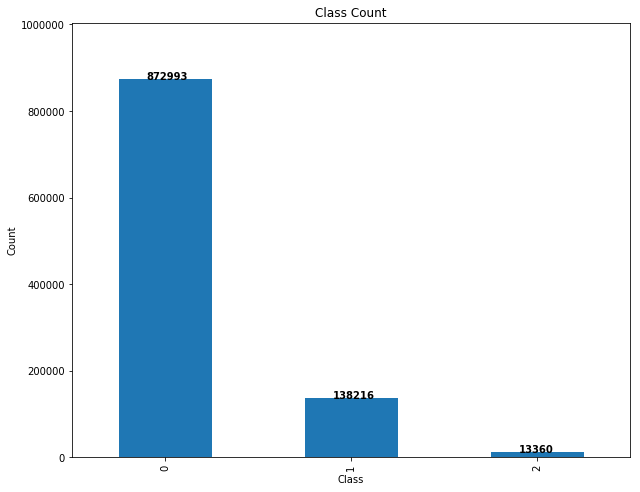

In [27]:
plt.figure(figsize=(10,8))
df['class'].value_counts().plot(kind='bar', title='Count - Class');
plt.title('Class Count')
plt.xlabel('Class');
plt.ylabel('Count');

count_class_0, count_class_1, count_class_2 = df['class'].value_counts()

plt.ylim([0, max([count_class_0, count_class_1, count_class_2])*1.15])
plt.text(-0.10, count_class_0-1000, count_class_0, fontweight='bold')
plt.text(0.90, count_class_1-1000, count_class_1, fontweight='bold')
plt.text(1.90, count_class_2-500, count_class_2, fontweight='bold')

Using the <b>class</b> column, it is clear according to the bar graph above that the vast majority of all rows represent hours in which the weather was clear. This can wreck havok on a model's ability to make accurate predicitons, as having discrepencies in the frequency of different classes can cause the model to be more or less likely to choose a certain class. 

One method that can be used to deal with this class discrepency is known as undersampling, in which the classes with higher frequency are randomly resampled so that they have the same frequency as the class with the lowest frequency. The next two cells implement this process so that the clear weather (0) and rainy weather (1) class have the same frequency as the snowy weather class (2). A new dataframe was created to hold the undersampled data, named ```df_us```.

In [28]:
df_class_0 = df[df['class'] == 0]
df_class_1 = df[df['class'] == 1]
df_class_2 = df[df['class'] == 2]

count_class_0, count_class_1, count_class_2 = df['class'].value_counts()

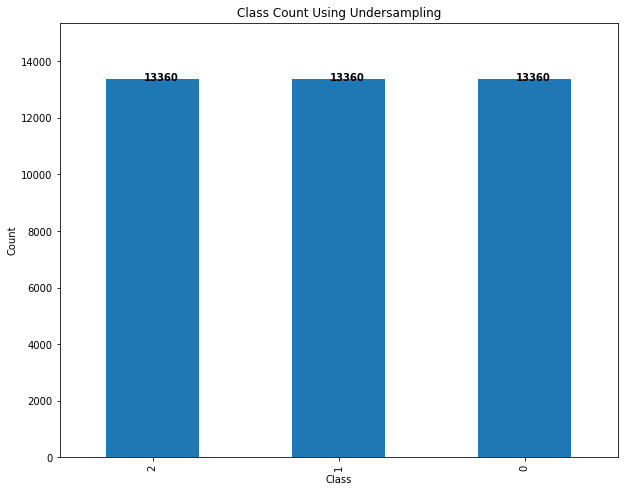

In [29]:
df_under_0 = df_class_0.sample(count_class_2, random_state=rs)
df_under_1 = df_class_1.sample(count_class_2, random_state=rs)
df_us = pd.concat([df_under_0, df_under_1, df_class_2], axis=0).reset_index(drop=True)

plt.figure(figsize=(10,8))
df_us['class'].value_counts().plot(kind='bar');
plt.title('Class Count Using Undersampling')
plt.xlabel('Class');
plt.ylabel('Count');

count0, count1, count2 = df_us['class'].value_counts()

plt.ylim([0, max([count0, count1, count2])*1.15])
plt.text(1.95, count0-25, count0, fontweight='bold')
plt.text(0.95, count1-25, count1, fontweight='bold')
plt.text(-0.05, count2-25, count2, fontweight='bold');

As we can see in the histrogram above, each class now has an equal number of instances. However, before proceeding, the code in the next cell makes sure that the class distribution is still relatively equal for each value of <b>num_hours</b>.

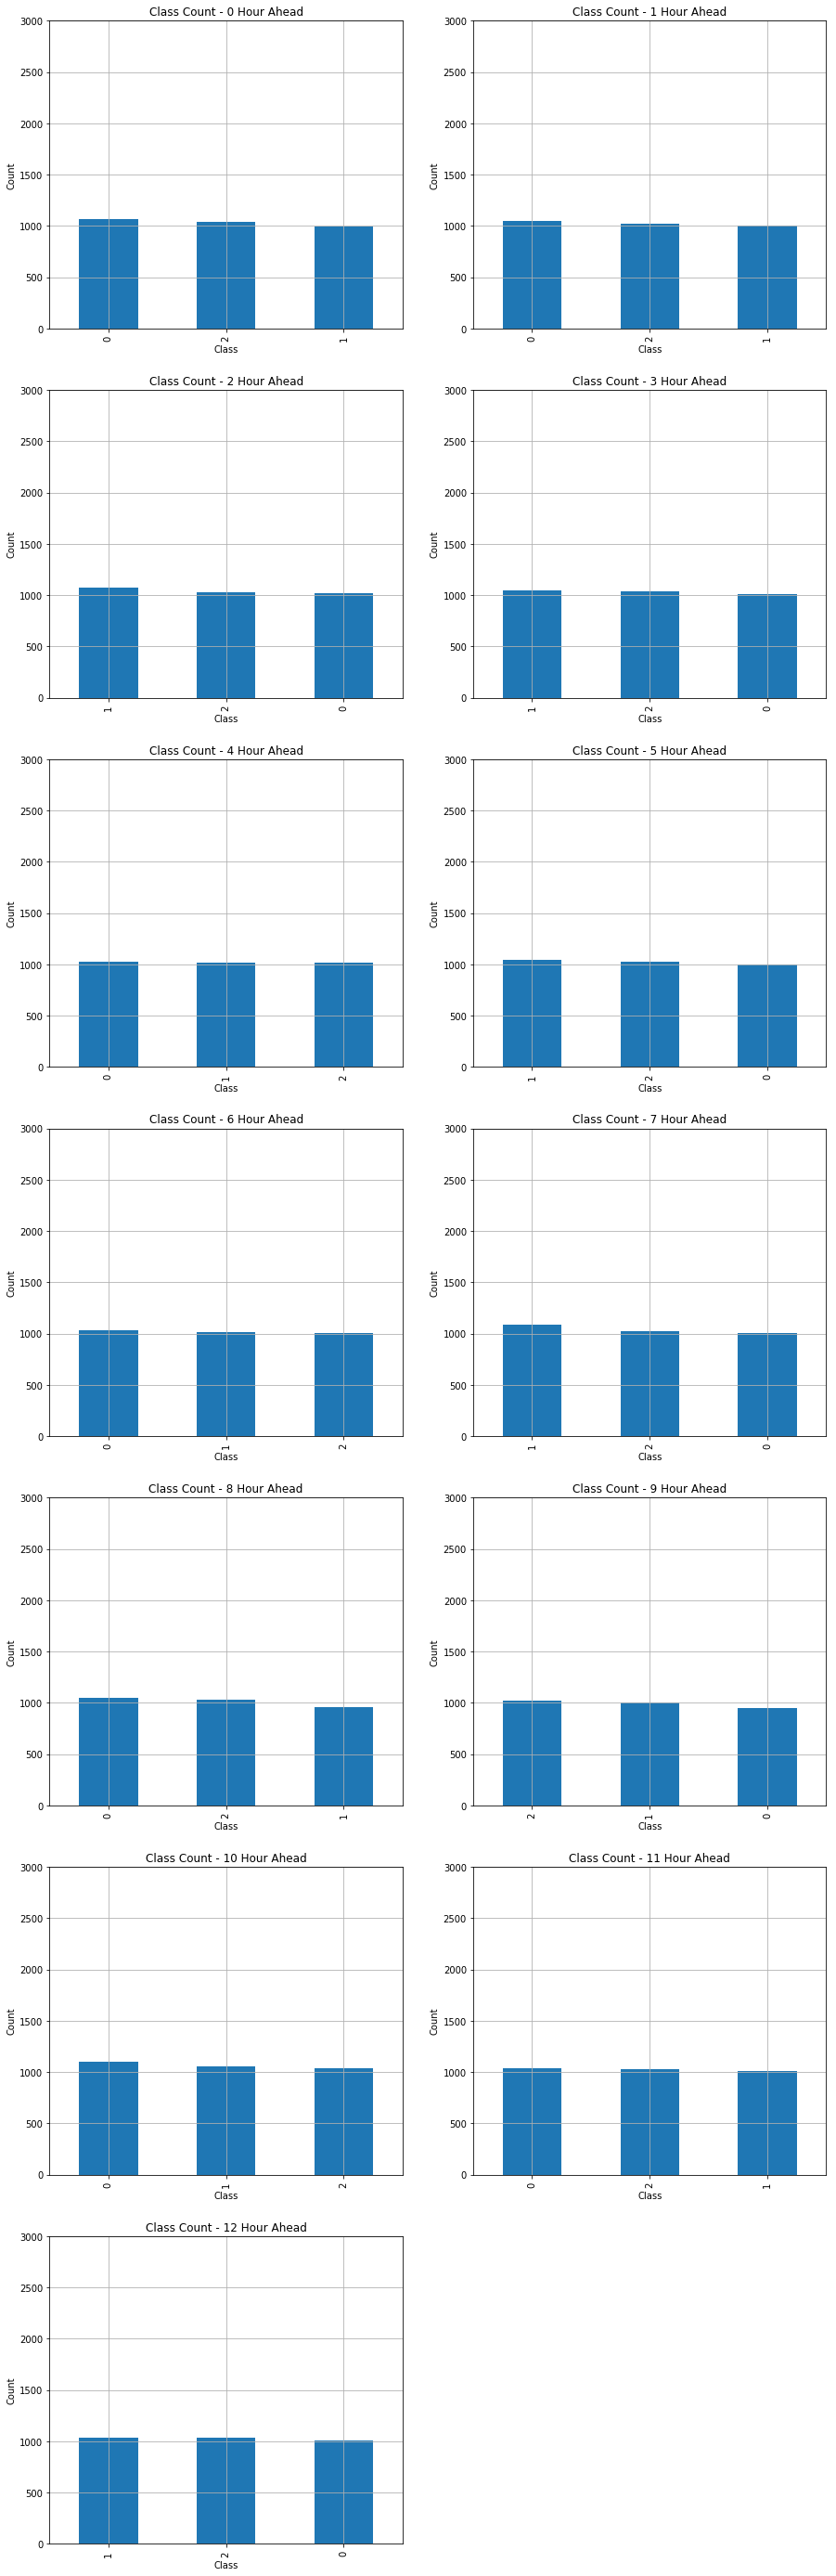

In [30]:
plt.figure(figsize=(15,50))
for i in range(0, 13):
    plt.subplot(7, 2, i+1)
    df_us[df_us['num_hours']==i]['class'].value_counts().plot(kind='bar')
    plt.title('Class Count - %d Hour Ahead' %i)
    plt.grid()
    plt.ylim([0,3000])
    plt.xlabel('Class')
    plt.ylabel('Count')

In [31]:
print('Class Value Counts:')
print(df_us['class'].value_counts())

print('\n')
print('Num Hours Value Counts:')
print(df_us['num_hours'].value_counts())

Class Value Counts:
2    13360
1    13360
0    13360
Name: class, dtype: int64


Num Hours Value Counts:
10    3197
2     3121
7     3118
0     3108
3     3101
12    3085
1     3079
11    3069
5     3065
4     3060
6     3049
8     3048
9     2980
Name: num_hours, dtype: int64


The histograms and the printout above make it clear that the data has been sufficiently undersampled. While the separation is not perfect for each value of <b>num_hours</b>, the class discrepencies are still very small and should not impact the results of any future predictive modeling or analysis. However, the downside of the undersampling technique is that it results in a huge loss of data (40,080 rows compared to 1,138,410 rows). Some of this data could be potentially very useful (especially in predicting the originally lower frequency classes) possibly resulting in bad generalizaiton to unseen data. For this reason, the next section compares results generated with the undersampled dataframe with results using sampling method, known as the Synthetic Minority Oversampling Technique (SMOTE).

The code below shows the ```.info()``` printout of the ```df_us``` dataframe.

In [32]:
df_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40080 entries, 0 to 40079
Data columns (total 24 columns):
year                   40080 non-null int64
month                  40080 non-null int64
day                    40080 non-null int64
hour                   40080 non-null int64
temperature            40080 non-null float64
humidity               40080 non-null float64
mslp                   40080 non-null float64
rainfall_hr            40080 non-null float64
snowfall_hr            40080 non-null float64
total_cloud_cover      40080 non-null float64
high_cloud_cover       40080 non-null float64
medium_cloud_cover     40080 non-null float64
low_cloud_cover        40080 non-null float64
sunshine_duration      40080 non-null float64
shortwave_radiation    40080 non-null float64
wind_speed_10m         40080 non-null float64
wind_dir_10m           40080 non-null float64
wind_speed_80m         40080 non-null float64
wind_dir_80m           40080 non-null float64
wind_speed_900mb       40

## Section 3: Exploratory Data Analysis (EDA)

To recap, the conclusion of the data cleaning section resulted in two dataframes:

  - ```df```: consists of 87,570 rows of atmospheric data along with their corresponding target variables for predictions made 0-12 hours into the future (87,570 x 13 = 1,138,410 rows in total).
  - ```df_us```: An undersampled version of the ```df``` dataframe. Contains the same information as above but is resampled so that the frequency of each class matches the lowest frequency class (the snowy weather class). Contains 40,080 rows in total. 
  - ```df_test```: A test set containing a subset of approximately one year of data. Rows were selected randomly from the original ```df``` dataframe and then removed. Was created in order to see how any predictive algorithms perform on unseen data. 
  
  
  
The work done in this section is meant to explore the data in these dataframes in preparation for future modeling (specifically with neural networks). Various statistical methods and machine learning algorithms are used to gain a better understanding of the data and to determine how to best move forward in building more complex predictive models. 

### 3.1: Predictor Variable Histograms

The code in the cell below creates histograms for each of the predictor variables using the <b>df_us</b> dataframe.

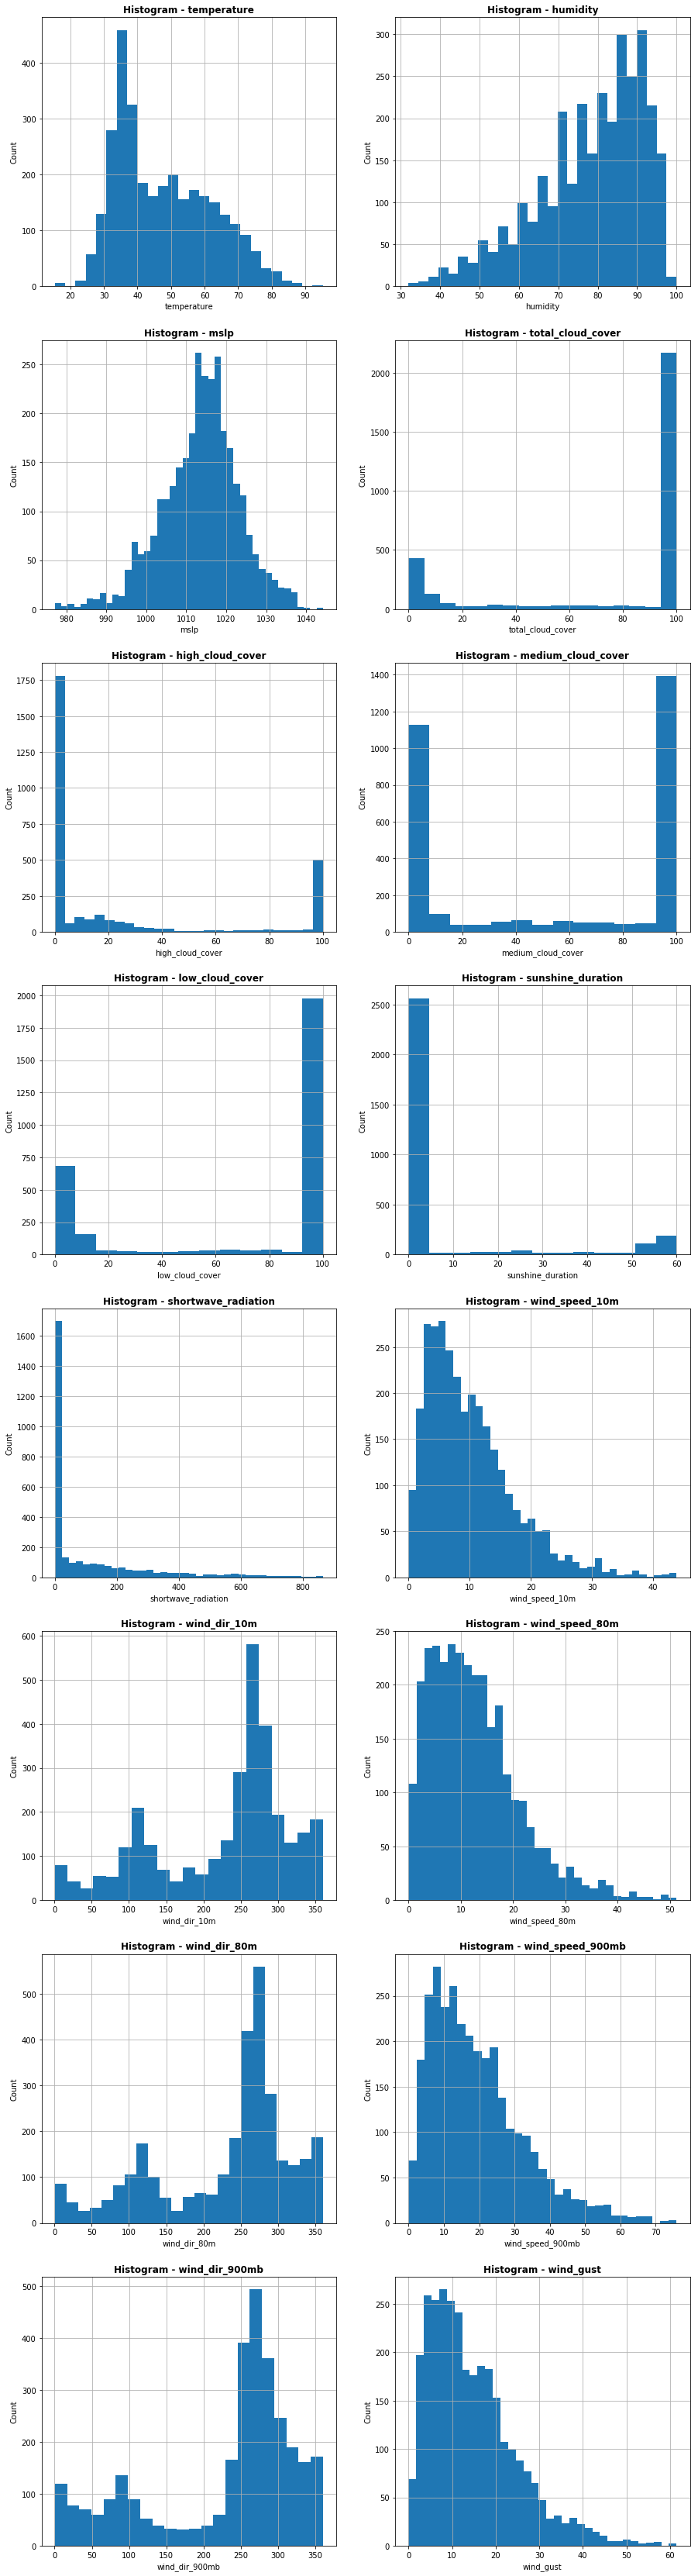

In [33]:
cols_for_hist = ['temperature', 'humidity', 'mslp', \
                 'total_cloud_cover', 'high_cloud_cover', 'medium_cloud_cover', \
                 'low_cloud_cover', 'sunshine_duration', 'shortwave_radiation', 'wind_speed_10m', 'wind_dir_10m',\
                 'wind_speed_80m', 'wind_dir_80m', 'wind_speed_900mb', 'wind_dir_900mb', 'wind_gust']
plt.figure(figsize=(15,60))
plotnum = 1
for column in cols_for_hist:
    plt.subplot(len(cols_for_hist)/2, 2, plotnum)
    plotnum += 1
    plt.hist(x=df_us[df_us['num_hours']==0][column], bins='auto')
    plt.grid()
    plt.title('Histogram - {}'.format(column), fontweight='bold')
    plt.ylabel('Count')
    plt.xlabel(column)

The histograms above reveal some interesting insights into the weather patterns that exist in Basel. For example, the temperature histogram reveals that the most common temperature in the city is in the mid 30s (quite chilly!). In addition, it almost never gets above 90 degrees. This makes sense given the fact that Basel exists at both a high latitude and elevation. Another observaiton is the fact that for all of the wind direction histograms, there is a high peak at around 270$^{\circ}$ and a smaller one around 100$^{\circ}$. Given that 0$^{\circ}$ is north, this corresponds to winds heading in the east and west direction. In other words, the strongest winds that blow through Basel will more often or not be in these two directions. 

### 3.2: Scatterplots of Predictor Variables vs. Target Variables

While the conclusions that can be drawn from these histograms are interesting, they provide no insight to how they relate to the target varible (whether or not it rained or snowed). The code below does this by creating scatter plots of each predictor variable as a function of the <b>rainfall_hr</b> and <b>snowfall_hr</b> variables using the ```df_us``` dataframe. 

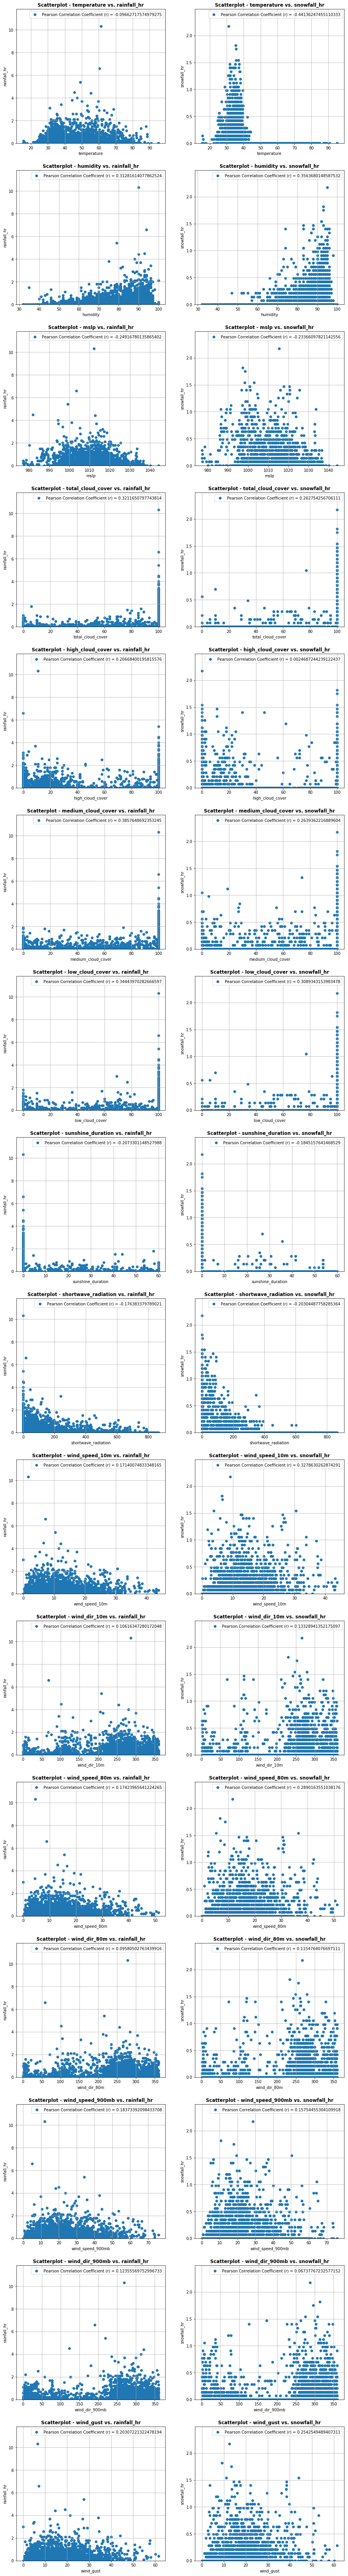

In [34]:
x_scatter_cols = ['temperature', 'humidity', 'mslp', \
                 'total_cloud_cover', 'high_cloud_cover', 'medium_cloud_cover', \
                 'low_cloud_cover', 'sunshine_duration', 'shortwave_radiation', 'wind_speed_10m', 'wind_dir_10m',\
                 'wind_speed_80m', 'wind_dir_80m', 'wind_speed_900mb', 'wind_dir_900mb', 'wind_gust']
y_scatter_cols = ['rainfall_hr', 'snowfall_hr']
plt.figure(figsize=(15,120))
plotnum = 1
for x_col in x_scatter_cols:
    for y_col in y_scatter_cols:
        plt.subplot(len(x_scatter_cols), len(y_scatter_cols), plotnum)
        plotnum +=1
        r = pearsonr(x=df_us[df_us['num_hours']==0][x_col], y=df_us[df_us['num_hours']==0][y_col])[0]
        plt.scatter(x=df_us[df_us['num_hours']==0][x_col], y=df_us[df_us['num_hours']==0][y_col], \
                   label='Pearson Correlation Coefficient (r) = {}'.format(r))
        plt.legend()
        plt.ylim([0, max(df_us[df_us['num_hours']==0][y_col])*1.15])
        plt.grid()
        plt.title('Scatterplot - %s vs. %s' %(x_col, y_col), fontweight='bold')
        plt.ylabel(y_col)
        plt.xlabel(x_col)

The scatterplots above also provide some interesting insights. For example, the highest value of $r$ resulted from correlating the <b>temperature</b> column with the <b>snowfall_hr</b> column. However, there was almost no correlation between <b>temperature</b> and <b>rainfall_hr</b>. This is likely due to the fact that it can rain in almost any temperature weather, but it can only snow if the temperature is below a certain value. However, in general the $r$ value never went much above 0.3, indicating slight, albeit existant, positive correlations between the predictor and target variables.  

### 3.3: K-Nearest-Neighbor Classifier Analysis
In order to establish a baseline for our neural network performance, the work done here presents an analysis using the much simpler k-nearest-neighbor algorithm. Given the fact that neural networks can build incredibly sophisticated models, it should be the case that they would outperform the results seen here. 

In addition to establishing a baseline, the work done in this section is the first time the validity of the undersampling method is tested. As mentioned at the end of Section 2, another sampling method known as the Synthetic Minority Over-Sampling Technique (SMOTE) is implemented here, and evidence is given that it results in  better performance compared to the undersampling method. 

The cell below prepares the data for analysis by the k-nearest neighbor algorithm using the ```prepare_data()``` function (see Section 0.2). In short, the function returns training, validation, and testing sets for both the predictor and target variables, and is capable of performing other data preprocessing tasks via the inclusion of various arguments. The training and validation sets are created from the dataframe given to the function as an argument, while the testing sets are created using the ```df_test``` dataframe constructed in Section 2. The <b>df_us</b> dataframe is used in this case and only rows for which the <b>num_hours</b> column equals 0.

In [35]:
cols_to_drop = ['year', 'month', 'day', 'hour', 'rainfall_hr', 'snowfall_hr', 'num_hours', 'class']

# Data Preparation Steps Hidden by prepare_data():
#X = df_us[df_us['num_hours']==0].drop(columns=cols_to_drop).values
#y = df_us[df_us['num_hours']==0]['class'].values
#X_test = df_test[df_test['num_hours']==0].drop(columns=cols_to_drop).values
#y_test = df_test[df_test['num_hours']==0]['class'].values
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)

X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_us, num_hours=0)

The cell below uses the training and validation sets created above to generate a graph of how the ```KNeighborsClassifier``` performs for different number of neighbors. The number of neighbors is modified by adjusting the ```n_neighbors``` argument of the ```KNeighborsClassifer``` class. 

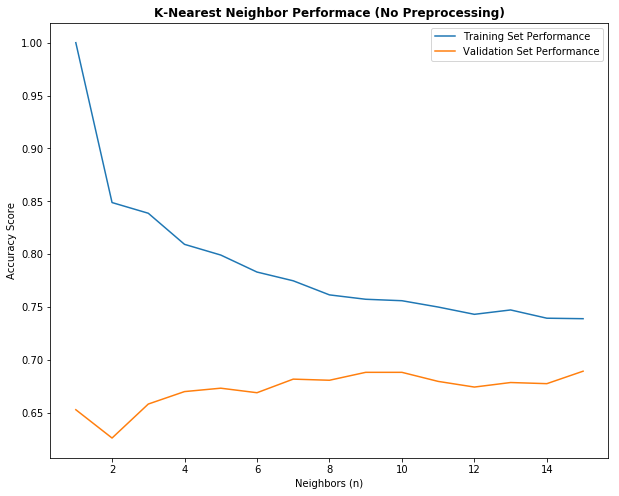

In [36]:
plt.figure(figsize = (10, 8))
max_n = 15
neighbors = np.arange(1, max_n+1)
train_scores = np.empty(len(neighbors))
val_scores = np.empty(len(neighbors))
for i, k in enumerate(neighbors):
    knn_tmp = KNeighborsClassifier(n_neighbors = k)
    knn_tmp.fit(X_train, y_train)
    train_scores[i] = knn_tmp.score(X_train, y_train)
    val_scores[i] = knn_tmp.score(X_val, y_val)

plt.plot(neighbors, train_scores, label = 'Training Set Performance')
plt.plot(neighbors, val_scores, label = 'Validation Set Performance')
plt.legend(loc='upper right')
plt.xlabel('Neighbors (n)')
plt.ylabel('Accuracy Score')
plt.title('K-Nearest Neighbor Performace (No Preprocessing)', fontweight='bold');

In [37]:
best_val_score = max(val_scores)
best_k = neighbors[np.where(val_scores == best_val_score)][0]
print('K-Nearest Neighbor Model Results (No Preprocessing):\n')
print('Best Validation Data Performance: %3.2f' %best_val_score)
print('Optimal Number of Neighbors: %d' % best_k)


K-Nearest Neighbor Model Results (No Preprocessing):

Best Validation Data Performance: 0.69
Optimal Number of Neighbors: 15


According to the graph and printout above, the ```KNeighborsClassifier``` had the highest validation set accuracy using 15 neighbors and was about 69%. This is already not terrible performance, and was achieved without any preprocessing of the data. 

Because we are dealing with weather data, it is probably not incorrect to assume that many of the independent variables incldued in this analysis are correlated with themselves. For example, the graph below shows a scatterplot of <b>temperature</b> vs. <b>humidity</b>.

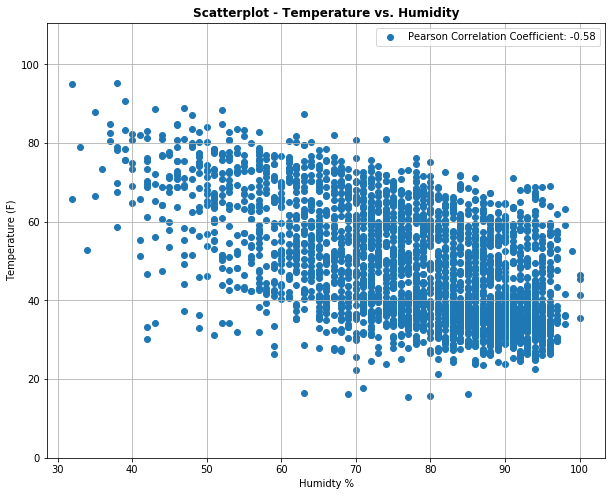

In [38]:
plt.figure(figsize = (10, 8))
r = pearsonr(df_us[df_us['num_hours']==0].humidity, df_us[df_us['num_hours']==0].temperature)[0]
plt.scatter(x=df_us[df_us['num_hours']==0].humidity, y=df_us[df_us['num_hours']==0].temperature, label =\
         'Pearson Correlation Coefficient: %2.2f' %r)
plt.title('Scatterplot - Temperature vs. Humidity', fontweight='bold')
pearsonr(df_us.humidity, df_us.temperature)[0]
plt.xlabel('Humidty %')
plt.legend()
plt.grid()
plt.ylim([0, max(df_us.temperature)*1.15])
plt.ylabel('Temperature (F)');
#pearsonr(df_undersample.humidity, df_undersample.temperature)[0]

Indeed we see that these two variables exhibit quite a strong negative correlation. These correlations most likely exist between a number of other combinations of independent variables. As such, the ```KNeighborsClassifier``` would most likely benefit from a principal component analysis, which removes these correlations. In addition, since the scales of the independent variables vary greatly, scaling the data using a ```StandardScaler``` would also likely improve performance. A principal component analysis using data scaled by a ```StandardScaler``` is done in the cell below. Once again, the data comes from the ```df_us``` dataframe for which <b>num_hours</b> equals 0. 

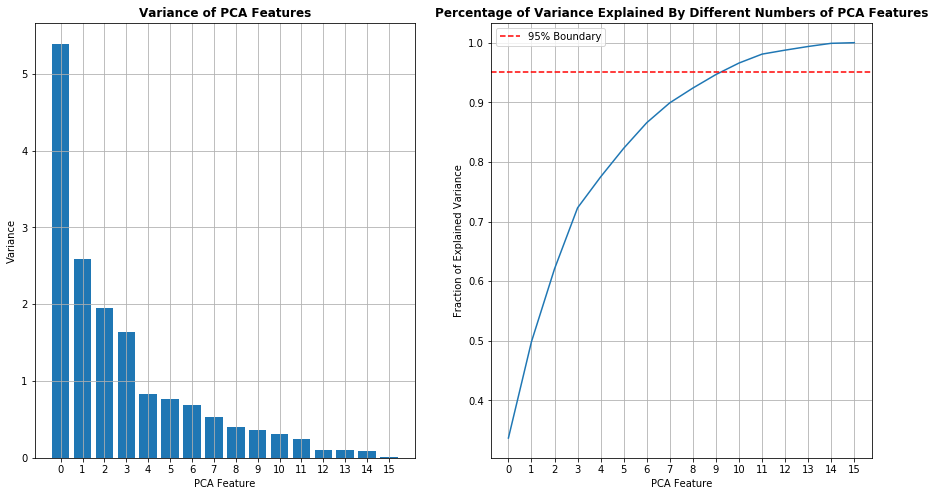

In [39]:
X = df_us[df_us['num_hours']==0].drop(columns=cols_to_drop).values
y = df_us[df_us['num_hours']==0]['class'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(X_train)

plt.figure(figsize=(15,8))
features = range(pca.n_components_)

plt.subplot(1, 2, 1)
plt.bar(features, pca.explained_variance_)
plt.title('Variance of PCA Features', fontweight='bold')
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.grid()
plt.xticks(features)


plt.subplot(1, 2, 2)
plt.plot(features, np.cumsum(pca.explained_variance_ratio_))
plt.title('Percentage of Variance Explained By Different Numbers of PCA Features', fontweight='bold')
plt.xlabel('PCA Feature')
plt.axhline(y=0.95, color = 'red', linestyle='--', label='95% Boundary')
plt.legend()
plt.ylabel('Fraction of Explained Variance')
plt.grid()
plt.xticks(features);

In [40]:
total = 0
best_n = 0
for percent in pca.explained_variance_ratio_:
    total += percent
    best_n += 1
    if total >= 0.95:
        break

print('%d PCA Features explain %2.2f %% of the variance.' %(best_n, total*100))

11 PCA Features explain 96.59 % of the variance.


According to the graphs and printout above, we see that 11 pca features are enough to explain more than 95% of the variance seen in the predictor variables. As such, this should be more than adaquate to help improve the performance of the ```KNeighborsClassifier```. The cells below show how the classifier's performance change using different number of neighbors, this time with appropriate data preprocessing (standard scaled data and a principal component analysis using 11 principal components). 

In [41]:
# Data Preparation Steps Hidden by prepare_data():
#X = df_us[df_us['num_hours']==0].drop(columns=cols_to_drop).values
#y = df_us[df_us['num_hours']==0]['class'].values
#X_test = df_test[df_test['num_hours']==0].drop(columns=cols_to_drop).values
#y_test = df_test[df_test['num_hours']==0]['class'].values
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
#scaler = StandardScaler()
#pca = PCA(n_components=best_n)
#pipeline = make_pipeline(scaler, pca)
#X_train = pipeline.fit_transform(X_train)
#X_val = pipeline.transform(X_val)

X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_us, num_hours=0, do_std_scaler=True, do_pca=best_n)

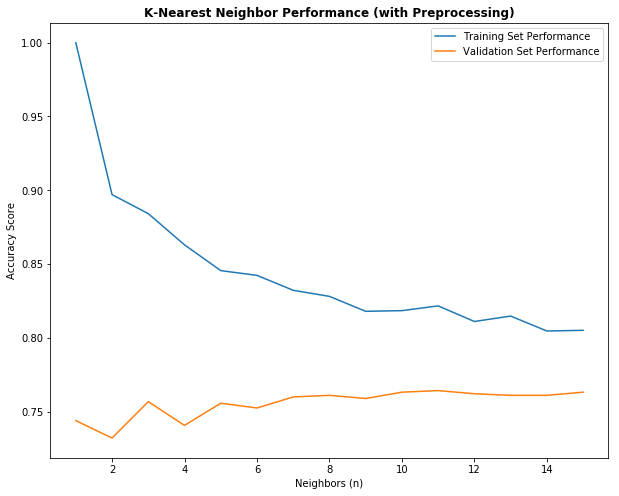

In [42]:
plt.figure(figsize = (10, 8))
max_n = 15
neighbors = np.arange(1, max_n+1)
train_scores = np.empty(len(neighbors))
val_scores = np.empty(len(neighbors))
for i, k in enumerate(neighbors):
    knn_tmp = KNeighborsClassifier(n_neighbors = k)
    knn_tmp.fit(X_train, y_train)
    train_scores[i] = knn_tmp.score(X_train, y_train)
    val_scores[i] = knn_tmp.score(X_val, y_val)

plt.plot(neighbors, train_scores, label = 'Training Set Performance')
plt.plot(neighbors, val_scores, label = 'Validation Set Performance')
plt.legend(loc='upper right')
plt.xlabel('Neighbors (n)')
plt.ylabel('Accuracy Score')
plt.title('K-Nearest Neighbor Performance (with Preprocessing)', fontweight='bold');

In [43]:
best_val_score = max(val_scores)
best_k = neighbors[np.where(val_scores == best_val_score)]
print('K-Nearest Neighbor Model Results (with Preprocessing):\n')
print('Best Valdition Set Performance: %3.2f' %best_val_score)
print('Optimal Number of Neighbors: %d' % best_k[0])

K-Nearest Neighbor Model Results (with Preprocessing):

Best Valdition Set Performance: 0.76
Optimal Number of Neighbors: 11


The results shown above do indeed indicate that the ```KNeighborsClassifer``` does indeed perform better as a result of the data preprocessing, and that it performs best on the validation set using 11 neighbors. By combining the use of data processing along with fine tuning the optimal number of neighbors, we can now see how the best possible ```KNeighborsClassifer``` performs on the test dataset. However, recall that the test dataset is not undersampled like the ```df_us``` dataset that has been used to train the classifier. As such, this also gives the first test of how the undersampling method will perform when attempting to generalize to new data. Due to the huge class discrepencies still present in the test data, accuracy is not the best indicator of how well the classifier performs. In this case, the precision, recall, and $F_1$ score for each class (as well as their averages) are much more suited as metrics to determine the predictive power of the ```KNeighborsClassifer``` on the test set. As a quick recap, the formulas for precision, recall, and $F_1$ score are shown below:

$$
\begin{align}
\text{Recall} &= \frac{t_p}{t_p+f_n} \\
\text{Precision} &= \frac{t_p}{t_p+f_p}  \\
F_1\text{Score} &= 2\cdot\frac{\text{Precision} \cdot \text{Recall}}{\text{Precision}+\text{Recall}}
\end{align}
$$

Given that,

<ul>
    <li>$t_p$ = Number of true positives.</li>
    <li>$f_p$ = Number of false positives. </li>
    <li>$f_n$ = Number of false negatives. </li>
</ul>

The function ```give_metrics()``` calculates all of these values for each class, along with their macro average. A macro average was chosen over a micro average due to the fact that it give equal importance to each class instead of weighting the most frequent classes more heavily. In other words, a macro average puts more emphasis on correctly identifying the less frequent classes. 

The cell below finally tests how the optimal ```KNeighborsClassifer``` performs on the test dataset:

In [44]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
give_metrics(y_test, predictions, 3)

Performance Metrics: 

Confusion Matrix:
[[5440 1405  522]
 [ 203  780  155]
 [   4    8   92]]


Class 0:
Recall:  0.7384281254241889
Precision:  0.963343368160085
F1 Score: 0.8360227447364378


Class 1:
Recall:  0.6854130052724078
Precision:  0.35567715458276333
F1 Score: 0.4683278294806364


Class 2:
Recall:  0.8846153846153846
Precision:  0.11963589076723016
F1 Score: 0.21076746849942726


Overall Metrics:
Total Accuracy:  0.7331862004878615
Average Recall (Macro):  0.7694855051039937
Average Precision (Macro) : 0.47955213783669287
Average F1 Score (Macro):  0.5908683714898908


According to the prinout above, we see that the accuracy of the ```KNeighborsClassifier``` is similar to its performance on the validation data (about 73%). However, perhaps more interesting is to look at both the precision and recall for class 1 and 2. While their values for recall are actually quite large, their precision values are very low. Looking at the confusion matrix, we can see why this is: the less frequent classes are <i>overpredicted</i>. This means that while a decent fraction of the snowy and rainy hours were correctly predicted (lending itself to the high recall), there were many times when they were predicted when they shouldn't have been (lending itself to the low precision). More specifically, the area in the top right corner of the confusion matrix points to the problem: there were 522 + 155 = 777 times when rainy or clear weather was predicted as snow, and 1,405 + 522 = 1,927 times when clear weather was predicted as rain or snow. This points to a problem in the undersampling method that was used to deal with the intial class discrepencies: it forces the algorithm to overestimate the number of rainy and snowy hours.

In order to have a comparision against the undersampling method, the next cell implements the oversampling method known as SMOTE, that was referenced earlier. The quote from Wikipedia below provides brief description of how SMOTE works: 

<i>Take a sample from the dataset, and consider its k nearest neighbors (in feature space). To create a synthetic data point, take the vector between one of those k neighbors, and the current data point. Multiply this vector by a random number x which lies between 0, and 1. Add this to the current data point to create the new, synthetic data point.</i>

The oversampled dataset is then used to train the ```KNeighborsClassifier```, and its performance is evaluated on the test set. 

In [45]:
# Data Preparation Steps Hidden by prepare_data():
#X = df[df['num_hours']==0].drop(columns=cols_to_drop).values
#y = df[df['num_hours']==0]['class'].values
#X_test = df_test[df_test['num_hours']==0].drop(columns=cols_to_drop).values
#y_test = df_test[df_test['num_hours']==0]['class'].values
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
#scaler = StandardScaler()
#pca = PCA(n_components = 11)
#pipeline = make_pipeline(scaler, pca)
#X_train = pipeline.transform(X_train)
#X_val = pipeline.transform(X_val)
#X_test = pipeline.transform(X_test)
#sm = SMOTE(random_state=rs)
#X_train, y_train = sm.fit_sample(X_train, y_train)

X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df, num_hours=0, do_std_scaler=True, \
                                                              do_pca=11, do_smote = True)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
print('Validation Set Score: ', knn.score(X_val, y_val))
print('\n')
give_metrics(y_test, predictions, 3)

Validation Set Score:  0.7846257756764743


Performance Metrics: 

Confusion Matrix:
[[5750 1417  200]
 [ 170  941   27]
 [   2   17   85]]


Class 0:
Recall:  0.7805076693362292
Precision:  0.9709557581898007
F1 Score: 0.8653773797877945


Class 1:
Recall:  0.8268892794376098
Precision:  0.39621052631578946
F1 Score: 0.5357244520352974


Class 2:
Recall:  0.8173076923076923
Precision:  0.2724358974358974
F1 Score: 0.40865384615384615


Overall Metrics:
Total Accuracy:  0.787083284934371
Average Recall (Macro):  0.8082348803605104
Average Precision (Macro) : 0.5465340606471626
Average F1 Score (Macro):  0.6521080868469682


By using SMOTE instead of undersampling, both average precision and total accuracy experience a significant increase. In addition, the high numbers that were previously seen in the top right corner of the confusion matrix are now much lower. While the classifier's performance on class 1 and 2 is still not ideal, switching to SMOTE as a way to deal with the class imbalances seems to provide better results. 

Before concluding the exploratory analysis using the ```KNeighborsClassifier```, one final aspect of the data was examined. The only data that has been analyzed up until this point has been data for which the <b>num_hours</b> column in the ```df``` and ```df_us``` dataframes is 0. In other words, we have only been looking at predictions that have been made within the same hour for which the atmospheric data has been taken. The two cells below explores how the quality of these predicitons changes the farther into the future these predictions are made. More specifically, the code determines the best ```KNeighborsClassifer``` for each hour of prediction, and plots its best corresponding validation set score.

In [46]:
tmp = []
for i in range(0, 13):
    subset = df_us[df_us['num_hours']==i]
    y = subset['class'].values
    X = subset.drop(columns=cols_to_drop).values
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
    scaler = StandardScaler()
    pca = PCA()
    pipeline = make_pipeline(scaler, pca)
    pipeline.fit(X_train)
    
    best_n = 0
    total = 0
    for percent in pca.explained_variance_ratio_:
        total += percent
        best_n += 1
        if total >= 0.95:
            break
    
    # Data Preparation Steps Hidden by prepare_data():
    #scaler = StandardScaler()
    #pca = PCA(n_components=best_n)
    #pipeline = make_pipeline(scaler, pca)
    #X_transform = pipeline.fit_transform(X)
    #X_train, X_val, y_train, y_val = train_test_split(X_transform, y, test_size=0.3, random_state=rs)
    
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_us, num_hours=i, do_std_scaler=True, \
                                                                  do_pca=best_n)
    
    max_n = 15
    neighbors = np.arange(1, max_n+1)
    train_scores = np.empty(len(neighbors))
    val_scores = np.empty(len(neighbors))
    for j, k in enumerate(neighbors):
        knn_tmp = KNeighborsClassifier(n_neighbors = k)
        knn_tmp.fit(X_train, y_train)
        train_scores[j] = knn_tmp.score(X_train, y_train)
        val_scores[j] = knn_tmp.score(X_val, y_val)
    best_val_score = max(val_scores)
    best_train_score = max(train_scores)
   
    tmp.append([i, best_train_score, best_val_score])
    
tmp = np.asarray(tmp)
KNN_performances_df = pd.DataFrame({'num_hours': tmp[:,0], 'best_train_performance': tmp[:,1],\
                                        'best_val_performance': tmp[:,2]})


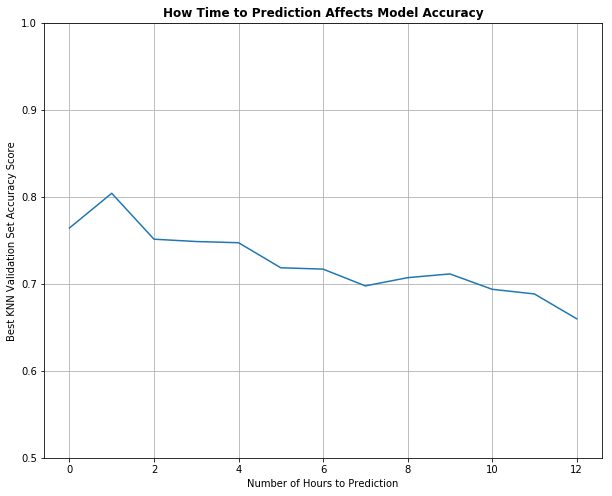

In [47]:
plt.figure(figsize = (10, 8))
plt.plot(KNN_performances_df.num_hours, KNN_performances_df.best_val_performance)
plt.ylim([0.5, 1])
plt.grid()
plt.title('How Time to Prediction Affects Model Accuracy', fontweight='bold')
plt.xlabel('Number of Hours to Prediction')
plt.ylabel('Best KNN Validation Set Accuracy Score');

As is probably to be expected, the best validation set score decreases as we try to make predictions further and further into the future. However, this gives us another reasonable benchmark to examine how other, more complex predictive models perform as the interval between when the measurements were taken and when we are making a prediction increases. 

### 3.4: Random Forest Classifier Analysis

The next and final step that was taken as part of the exploratory data analysis was to use a random forest classifier in order to examine the feature importances of the different predictor variables, as well as to further examine if SMOTE provides better results compared to the undersampled data in ```df_us```. The cell below creates a random forst classifer using the undersampled dataframe, ```df_us``` (without any hyperparameter tuning), and checks to see how well it performs on the test dataset (with <b>num_hours</b> equal to 0). Note that random forest classifiers do not typically need to invoke any initial scaling of the data.

In [48]:
# Data Preparation Steps Hidden by prepare_data():
#X = df_us[df_us['num_hours']==0].drop(columns=cols_to_drop).values
#y = df_us[df_us['num_hours']==0]['class'].values
#X_test = df_test[df_test['num_hours']==0].drop(columns=cols_to_drop).values
#y_test = df_test[df_test['num_hours']==0]['class'].values
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)

X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_us, num_hours=0)

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
predictions = rfc.predict(X_test)
print('Out of the box Random Forest Classifier Performance: ')
print('Validation Set Score: {}'.format(rfc.score(X_val, y_val)))
print('\n')
give_metrics(y_test, predictions, 3)

Out of the box Random Forest Classifier Performance: 
Validation Set Score: 0.8177920685959271


Performance Metrics: 

Confusion Matrix:
[[5650 1318  399]
 [ 262  830   46]
 [   2    1  101]]


Class 0:
Recall:  0.7669336229129904
Precision:  0.9553601623266824
F1 Score: 0.8508395452149687


Class 1:
Recall:  0.7293497363796133
Precision:  0.3862261516984644
F1 Score: 0.5050197748707028


Class 2:
Recall:  0.9711538461538461
Precision:  0.184981684981685
F1 Score: 0.31076923076923085


Overall Metrics:
Total Accuracy:  0.764432570565687
Average Recall (Macro):  0.82247906848215
Average Precision (Macro) : 0.5088559996689439
Average F1 Score (Macro):  0.628727385932221


/anaconda3/envs/datatools/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The printout above shows that this ```RandomForestClassifier``` performed about as well (and maybe a little worse), than the tuned ```KNeighborsClassifier``` using SMOTE. More specifically, the total accuracy, average recall, average precision, and average $F_1$ score are all slightly lower. The cell below checks to see if the ```RandomForestClassifier``` receives the same benefits from using SMOTE that the ```KNeighborsClassifier``` did. 

In [49]:
# Data Preparation Steps Hidden by prepare_data():
#X = df[df['num_hours']==0].drop(columns=cols_to_drop).values
#y = df[df['num_hours']==0]['class'].values
#X_test = df_test[df_test['num_hours']==0].drop(columns=cols_to_drop).values
#y_test = df_test[df_test['num_hours']==0]['class'].values
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
#sm = SMOTE(random_state=rs)
#X_train, y_train = sm.fit_sample(X_train, y_train)

X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df, num_hours=0, do_smote = True)

rfc.fit(X_train, y_train)
predictions = rfc.predict(X_test)
print('Validation Set Score: ', rfc.score(X_val, y_val))
print('\n')
give_metrics(y_test, predictions, 3)

Validation Set Score:  0.870361771286251


Performance Metrics: 

Confusion Matrix:
[[6626  660   81]
 [ 363  760   15]
 [  22    5   77]]


Class 0:
Recall:  0.8994163160038008
Precision:  0.9450862929681928
F1 Score: 0.9216859090276812


Class 1:
Recall:  0.6678383128295254
Precision:  0.5333333333333333
F1 Score: 0.593055013655872


Class 2:
Recall:  0.7403846153846154
Precision:  0.44508670520231214
F1 Score: 0.555956678700361


Overall Metrics:
Total Accuracy:  0.8668834940178882
Average Recall (Macro):  0.7692130814059807
Average Precision (Macro) : 0.6411687771679461
Average F1 Score (Macro):  0.6993785516857723


The results shown above point to the best performance thus far. Not only has the accuracy increased to around 87%, but the average precision and $F_1$ score increased as well. This is due to the significantly better performance this classifier had at predicting rainy or snowy hours. 

However, keep in mind that this ```RandomForestClassifier``` has still not undergone any hypyerparameter tuning to see if these results can be maximized. The code below uses ```RandomizedSearchCV``` to check certain combinations of initial conditions for the ```RandomForestClassifier```, and uses the macro averaged precision as the scoring function in order to determine which set of initial conditions is best. Accuracy, once again does not act as the best scoring function due to the fact that our imbalanced dataset means that a classifier can have a very high accuracy by just always predicting the most frequent class.

In [50]:
param_grid = {
    'max_depth': [2, 10, 100],
    'n_estimators': [50, 100, 200],
    'min_samples_leaf': np.arange(2, 6),
    'min_samples_split': np.arange(2, 6)
}


gscv = RandomizedSearchCV(rfc, param_grid, cv=3, scoring='precision_macro')
gscv.fit(X_train, y_train)

print('Best Random Forst Classifier Parameters:')
print(gscv.best_params_)

Best Random Forst Classifier Parameters:
{'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 100}


The above printout shows the best random forest classifier parameters, which are used below to create a new ```RandomForestClassifier``` below. This new classifier is then evaluated on the test set. 

In [51]:
rfc = RandomForestClassifier(max_depth=100, min_samples_leaf=2, min_samples_split=5, n_estimators=50)
rfc.fit(X_train, y_train)
predictions = rfc.predict(X_test)
print('Validation Set Score: ', rfc.score(X_val, y_val))
print('\n')
give_metrics(y_test, predictions, 3)

Validation Set Score:  0.8656760521761155


Performance Metrics: 

Confusion Matrix:
[[6534  739   94]
 [ 275  846   17]
 [  16    2   86]]


Class 0:
Recall:  0.8869281932944211
Precision:  0.9573626373626374
F1 Score: 0.9208004509582863


Class 1:
Recall:  0.7434094903339191
Precision:  0.5330812854442344
F1 Score: 0.6209174311926604


Class 2:
Recall:  0.8269230769230769
Precision:  0.4365482233502538
F1 Score: 0.5714285714285714


Overall Metrics:
Total Accuracy:  0.8672319665466373
Average Recall (Macro):  0.8190869201838057
Average Precision (Macro) : 0.6423307153857085
Average F1 Score (Macro):  0.7200196228639459


As can be seen from the results above, tuning the  ```RandomForestClassifier``` only slightly improved the results. While the total accuracy went down, it was at the exspense of slightly increasing the average recall, precision and $F_1$ score. However, now that we have created a tuned ```RandomForestClassifier```, we can use it to examine the feature importances of the 16 different predictor variables. This is done in the cells below:

In [52]:
feature_importances = pd.DataFrame(rfc.feature_importances_, \
                                   index = df_us[df_us['num_hours']==0].drop(columns=cols_to_drop).columns, \
                                   columns=['importance']).sort_values('importance', ascending=False)

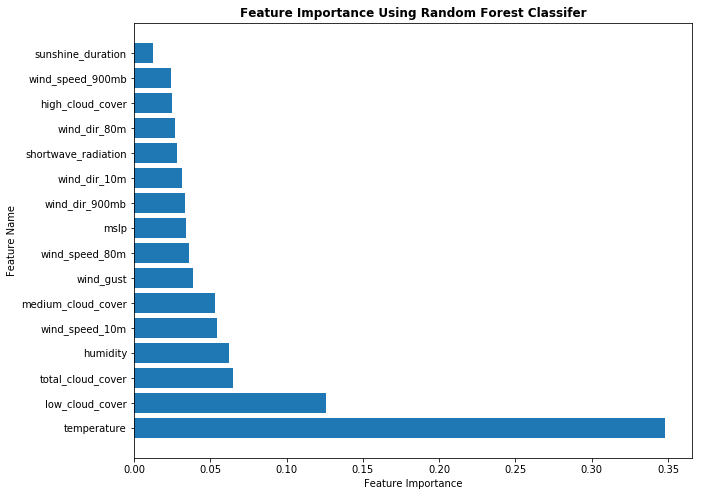

In [53]:
plt.figure(figsize=(10,8))
plt.barh(feature_importances.index, feature_importances.importance.values)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance Using Random Forest Classifer', fontweight='bold');

The graph above tells us that the four most imporant features (in decreasing order) are:
<ol>
    <li><b>Temperature</b></li>
    <li><b>Low Cloud Cover:</b> the % of sky covered by clouds < 2 km high.</li>
    <li><b>Total Cloud Cover:</b> The fraction of the sky covered by a cloud of any type at any height in the sky.</li>
    <li><b>Humidity</b></li>
</ol>

These features seem to make a lot of sense, and correspond well with the scatter plots seen earlier in this section. For example, temperature is no doubt extremely important in determining if there was snow or not considering that  snow only forms below a certain temperature. Cloud cover and humidity also make a lot of sense: in order for precipitation to occur, there needs to be a lot of clouds filled with a lot of moisture. Furthermore, clouds that are about to rain are filled with heavy water and tend to be lower in the sky compared to other types of clouds. As it turns out, the most common type of raincloud, the nimbostratus is a low altitude cloud. This is probably why low cloud cover has a higher feature importance when compared to medium or high cloud cover. However, we can examine these claims in more detail by making new histograms of these four features, but this time have them separated by class:

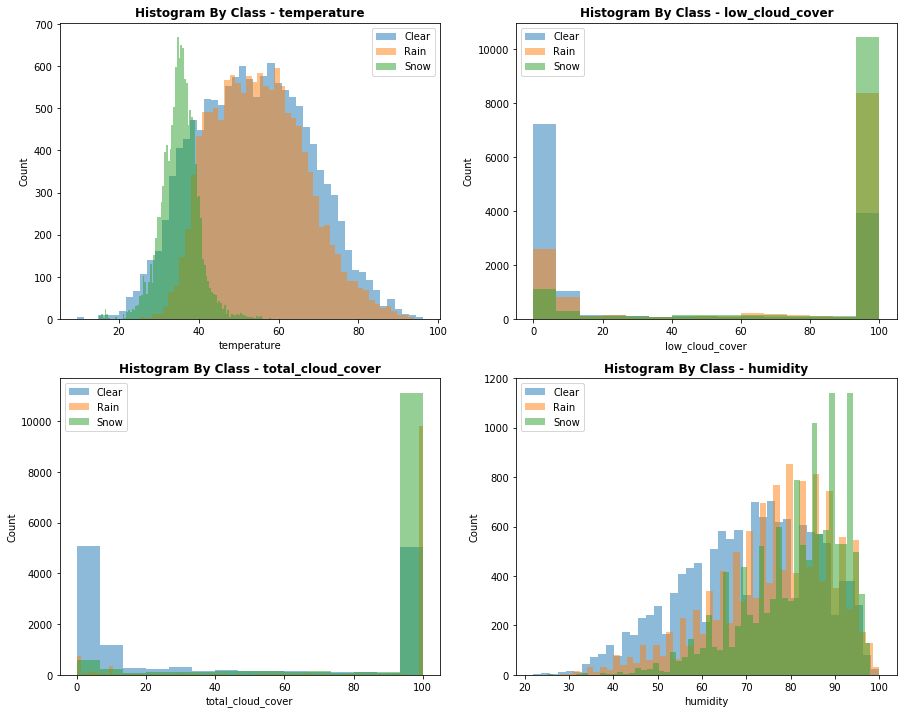

In [54]:
cols_to_hist = ['temperature', 'low_cloud_cover', 'total_cloud_cover', 'humidity']
plt.figure(figsize=(15, 12))
for i in range(4):
    plt.subplot(2, 2, i+1)
    class_0 = df_us[df_us['class']==0][cols_to_hist[i]]
    class_1 = df_us[df_us['class']==1][cols_to_hist[i]]
    class_2 = df_us[df_us['class']==2][cols_to_hist[i]]
    plt.hist(x=class_0, bins='auto', alpha=0.5, label = 'Clear')
    plt.hist(x=class_1, bins='auto', alpha=0.5, label = 'Rain')
    plt.hist(x=class_2, bins='auto', alpha=0.5, label = 'Snow')
    plt.legend()
    plt.xlabel(cols_to_hist[i])
    plt.ylabel('Count')
    plt.title('Histogram By Class - %s' %cols_to_hist[i], fontweight='bold')

We can see in the histograms above why the ```RandomForestClassifier``` chose these features as the most important. In each hisotgram some important differences between the three classes can be observed. For example, as predicted previously, the temperature histogram exhibits an extremely different curve for the snow data compared to the rain and clear data. In addition, for the two cloud cover histograms, the clear weather data peaks as 0% cloud cover, while the rainy and snowy weather data peaks at 100% cloud cover - another result that agrees with common sense. Finally, in the humidity histogram, we see that the clear weather data is shifted to the left of the rain and snow weather data, indicating that precipitation is usually accompanied by higher humidity levels.  

### 3.5: Section 3 Summary
The work done in this section was meant to elucidate the more important aspects of the data and to determine baselines of performance for the in depth analysis that follows. In summary, a few key results were identified by the work done in this section: 
<ol>
    <li><b>Using the undersampled data to fit predictive models does not generalize well, and results in poor performance on the test set.</b></li>
    <li><b>Using the oversampling technique known as SMOTE resulted in models that were better (higher average precision and $F_1$ score) at dealing with the class imabalances seen in the test set. </b></li>
    <li><b>In general, accuracy scores begin to decrease as we attempt to make predictions that are farther into the future. </b></li>
    <li><b>Accuracy is not the best metric to judge the performance of any predictive classifier, given that the data is highly imbalanced.</b></li>
    <li><b>According to a fitted random forest classifier, the most important predictive features are temperature, low cloud cover, total cloud cover, and humidity.</b></li>
</ol>

In addition, the following table recaps the best performances for both the ```KNeighborsClassifier``` and ```RandomForestClassifier``` that were used in this section. 
<table style="width:60%">
  <tr>
    <th>Metric</th>
    <th>K-Neighbors Classifier</th> 
    <th>Random Forest Classifier</th>
  </tr>
  <tr>
    <td>Total Accuracy</td>
    <td>0.79</td>
    <td>0.87</td>
  </tr>
  <tr>
    <td>Average Recall (Macro)</td>
    <td>0.81</td>
    <td>0.82</td>
  </tr>
  <tr>
    <td>Average Precision (Macro)</td>
    <td>0.55</td>
    <td>0.64</td>
  </tr>
    <tr>
    <td>Average $F_1$ Score (Macro)</td>
    <td>0.64</td>
    <td>0.72</td>
  </tr>
</table>
​

## Section 4: In-Depth Analysis - Building Nueral Networks

The goal of this seciton is twofold: 
<ul>
    <li> To use the insights from the previous section to create a series of neural networks that predicts whether or not it will be clear, rainy, or snowy anywhere from 0-12 hours in the future, and </li>
    <li> To have the results of these neural networks produce results that are better than the baselines established in the previous section.</li>

The subsections shown below outline the processes that were taken in order to achieve these goals. 

### 4.1: Analysis of Precision and F1 Score as Loss Functions

In order to build a neural network, you need to establish a loss function that will be used during training to help establish the weights of the connections between the nodes of the network. Based on the results of the previous section, the best option would seem to train on a dataset that has been oversampled using SMOTE, with average precision (or $F_1$ score) as the loss function. However, this poses a few problems. Typically, the loss function is something that is minimized through a process known as gradient descent. For example, if mean squared error (MSE) is chosen as the loss function, during training the neural network will attempt to determine the weights between nodes that produce the smallest MSE. However, if we chose average precision or $F_1$ score as the loss function, the goal would be to maximize these scores, not minimize them. This is at odds with the very purpose of gradient descent (to find the minimum of a function), and is already enough to make these metrics seem like poor choices for the loss function. However, even if there was a way around this problem, precision and $F_1$ exhibit another trait that make them unusable: they are not differentiable everywhere. Because the process of gradient descent involves taking the derivative of the loss function in order to find its minimum, using functions that are not differentiable everywhere could create a lot of issues when trying to train the neural network. More information about gradient descent can be found <a href='https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html'> here.</a> To show this in a litte more detail, the cells below actually show plots of precision and $F_1$ score as a function of the number of true positives. 

In [55]:
def R(tp, fn):
    '''Given the number of true positives, return the recall.
    Number of false negatives is defined outside the function as a constant. 
    '''
    return tp / (tp + fn)
def P(tp, fp):
    '''Given the number of true positives, return the precision.
    Number of flase positives is defined outside the function as a constant.
    '''
    return tp / (tp + fp)
def F1(tp, fp, fn):
    '''Given the number of true positives, return the precision.
    Number of flase negatives and false positives are defined outside the function as constants
    '''
    return 2 * (R(tp, fn) * P(tp, fp) / (R(tp, fn) + P(tp, fp)))

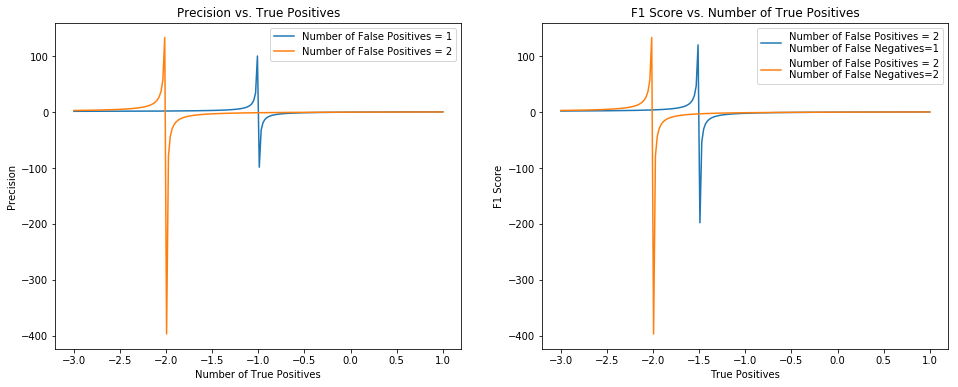

In [56]:
plt.figure(figsize = (16, 6))
plt.subplot(1, 2, 1)
tp = np.linspace(-3, 1, 200)
fp = 1
y_P = P(tp, fp) 
plt.plot(tp, y_P, label='Number of False Positives = 1')
tp = np.linspace(-3, 1, 200)
fp = 2
y_P = P(tp, fp) 
plt.plot(tp, y_P, label='Number of False Positives = 2')
plt.xlabel('Number of True Positives')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision vs. True Positives')

plt.subplot(1, 2, 2)
fn = 1
y_F1 = F1(tp, fp, fn)
plt.plot(tp, y_F1, label='Number of False Positives = 2\nNumber of False Negatives=1')
fn= 2
y_F1 = F1(tp, fp, fn)
plt.plot(tp, y_F1, label='Number of False Positives = 2\nNumber of False Negatives=2')
plt.title('F1 Score vs. Number of True Positives')
plt.xlabel('True Positives')
plt.legend()
plt.ylabel('F1 Score');

The asymptotic (and thus, non-differentiable) behavior of the two functions can be seen clearly above. More specifically, the precision function and $F_1$ both posess vertical asymptotes when the number of true positives is equal to a specific value. These values can be solved for algebraically by setting the denominator of each function equal to 0 and solving:

$$
\begin{align}
\text{precision} &= \frac{t_p}{t_p+f_n} \\
0 &= t_p + f_n \\
t_p &= -f_n 
\end{align}
$$

Thus, precision has a vertical asymptote when $t_p$ = $-f_n$. For $F_1$ score:

$$
\begin{align}
F_1\text{Score} &= 2\cdot\frac{\text{Precision} \cdot \text{Recall}}{\text{Precision}+\text{Recall}} \\
0 &= \text{Precision}+\text{Recall}\\
0 &= \frac{t_p}{t_p+f_n} + \frac{t_p}{t_p+f_p} \\
0 &= \frac{2t_p^2 + t_pf_p + t_pf_n}{(t_p+f_n)(t_p+f_p)} \\
0 &= t_p(2t_p + f_n + f_p) \\
2t_p &= -f_n - f_p \\
t_p &= \frac{-(f_n + f_p)}{2} 
\end{align}
$$

And thus $F_1$ score has a vertical asymptote when $t_p$ = $-(f_n+f_p)/2$. You may note that the number of true positives can never be negative, but if there are no false negatives and/or false positives, then the asymptotes occur when $t_p$ = 0, which is a realizable value.

In summary, in order to build a working neural network, a different methodology that does not invoke these funcitons needs to be implemented. 

### 4.2: Determining the Best Methodology 
It turns out that there are a number of ways that neural networks can deal with imbalanced data. For the purposes of this project, three different methodologies will be invoked and compared. They are as follows:

<ul>
    <li><b>Option 1: </b>Use SMOTE to oversample training data with sparse categorical cross entropy as the loss funciton.</li>
    <li><b>Option 2: </b>Fit the neural network by giving class weights that modify the contribution that each training example imputes when calculating the loss function. Use sparse categorical cross entropy as the loss function.</li>
    <li><b>Option 3: </b>Use the loss function known as focal loss, which down-weights well classified examples. </li>
</ul>

In order to compare each of the options listed above, they are all implemented below using data in ```df``` for when <b>num_hours</b> is equal to 0.

#### 4.2.1: Option 1 - Using SMOTE

The first option involves using SMOTE to oversample the data, which provided better results in the previous section compared to using the undersampled data. The loss function that will be used to build the neural network is known as sparse categorical cross entropy, and works by taking the negative log of the predicted probability of the correct class. For example, let's say that for a training example the neural network predicts the probabilities for three different classes as [0.2, 0.6, 0.2], when the actual class is [0, 1, 0]. The categorical cross entropy for this training exmaple will then be $-\log 0.6 \approx .22$. Note that the closer the neural network is to predicting the correct class, the smaller the contribution to the loss function. A quick graph of $y = -\log x$ makes this clear:

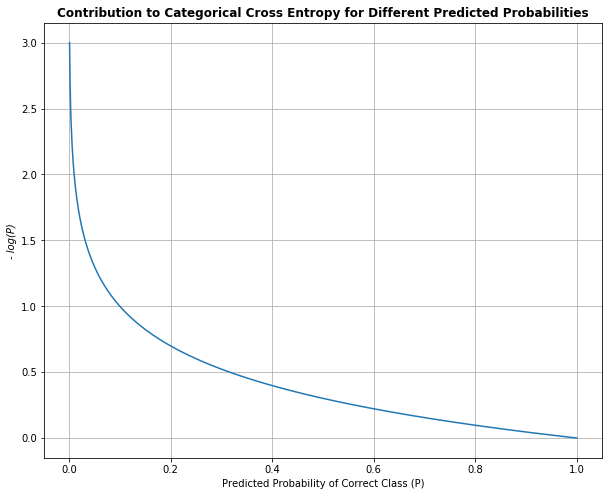

In [57]:
p = np.linspace(0.001, 1, 1000)
plt.figure(figsize=(10,8))
plt.plot(p, -np.log10(p))
plt.grid()
plt.xlabel('Predicted Probability of Correct Class (P)')
plt.ylabel('- log(P)', fontstyle='italic')
plt.title('Contribution to Categorical Cross Entropy for Different Predicted Probabilities', fontweight='bold');

The total value of the categorical cross entropy loss function is then the average of these logarithms. This is expressed mathematically below:

$$
\text{categorical cross entropy} = -\frac{1}{N}\sum_{s \in S} \log P(s \in c) 
$$

In the equation, $S$ is the sample data, $s$ is an element of the sample data and $P(s \in c)$ is the predicted probability that $s$ is in its correct class $c$. Note that the sparse part of the categorical cross entropy function simply means that the data it takes in must be multihot encoded as opposed to being one hot encoded. This seems like the better choice considering that this is already how the data is represented in ```df```, and that the classes are mutually exclusive. Sparse categorical cross entropy also has the added benefit of using less memory, given that the classes are represented by single numbers as opposed to vectors.

Now that categorical cross entropy has been fully explained, the cell below uses it in conjunction with SMOTE in order to build a neural network in ```keras```:

In [58]:
# Data Preparation Steps Hidden by prepare_data():
#X = df[df['num_hours']==0].drop(columns=cols_to_drop).values
#y = df[df['num_hours']==0]['class'].values
#X_test = df_test[df_test['num_hours']==0].drop(columns=cols_to_drop).values
#y_test = df_test[df_test['num_hours']==0]['class'].values
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
#scaler = MinMaxScaler(feature_range=(0,1))
#X_train = scaler.fit_transform(X_train)
#X_val = scaler.transform(X_val)
#X_test = scaler.transform(X_test)
#sm = SMOTE(random_state=rs)
#X_train, y_train = sm.fit_sample(X_train, y_train)

X_train, X_val, X_test, y_train, y_val, y_test = \
prepare_data(df, num_hours=0, do_min_max_scaler = True, do_smote = True)

In [59]:
# define structure of model
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(16, )))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(3, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


Note that the structure above - three hidden layers with 50, 100, and 50 nodes, respectively -  is a relatively common structure used for building neural networks and will be used in order to compare the three different methodologies being tested. The code below compiles and fits the model using the Adam optimizer with a learning rate of 0.001 (another common choice) and the sparse categorical crossentropy loss function that was previously discussed. 

In [60]:
adam = keras.optimizers.Adam(0.001)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, verbose=True)

Instructions for updating:
Use tf.cast instead.
Train on 141207 samples, validate on 23689 samples
Epoch 1/10
141207/141207 [==============================] - 9s 65us/step - loss: 0.3925 - acc: 0.8406 - val_loss: 0.4435 - val_acc: 0.7962
Epoch 2/10
141207/141207 [==============================] - 8s 59us/step - loss: 0.3277 - acc: 0.8678 - val_loss: 0.4832 - val_acc: 0.77002s - loss: 0.3320 - acc: 0 - ETA: 2s - loss: 0.3309 - ETA: 1s 
Epoch 3/10
141207/141207 [==============================] - 8s 58us/step - loss: 0.3109 - acc: 0.8751 - val_loss: 0.4558 - val_acc: 0.7903
Epoch 4/10
141207/141207 [==============================] - 9s 63us/step - loss: 0.2996 - acc: 0.8808 - val_loss: 0.4102 - val_acc: 0.8078
Epoch 5/10
141207/141207 [==============================] - 10s 68us/step - loss: 0.2907 - acc: 0.8840 - val_loss: 0.5845 - val_acc: 0.7453
Epoch 6/10
141207/141207 [==============================] - 9s 62us/step - loss: 0.2823 - acc: 0.8878 - val_loss: 0.4693 - val_acc: 0.7845
Epoc

Note that 10 epochs was also a random choice but viewed as a long enough amount of time for a model to learn a significant fraction of its best possible performance. Now that the model has been fitted, the cell below evaluates its performance on the test dataset. 

In [61]:
predictions = model.predict(X_test)
give_metrics(y_test, np.argmax(predictions, axis=1), 3)

Performance Metrics: 

Confusion Matrix:
[[6182 1029  156]
 [ 224  886   28]
 [  16    1   87]]


Class 0:
Recall:  0.8391475498846206
Precision:  0.9626284646527562
F1 Score: 0.896656755384727


Class 1:
Recall:  0.7785588752196837
Precision:  0.46242171189979125
F1 Score: 0.5802226588081204


Class 2:
Recall:  0.8365384615384616
Precision:  0.3210332103321033
F1 Score: 0.464


Overall Metrics:
Total Accuracy:  0.831106981066326
Average Recall (Macro):  0.818081628880922
Average Precision (Macro) : 0.5820277956282168
Average F1 Score (Macro):  0.6801557632089149


The neural network in this case performed reasonably well, but still not as good as the best ```RandomForestClassifier``` used earlier. Let's evaluate the other two options to see if it improves performance. 

#### 4.2.2: Option 2 - Using Class Weights
Another option offered by the ```keras.fit()``` method is to use an argument known as ```class_weights```, which allows you to weight the contributions from each class on the loss function. For example, given a set of class weights $w_1, w_2, ..., w_C$ where $C$ is the set of all classes, the formula for the categorical crossentropy function mentioned earlier is modified as follows:

$$
\text{weighted categorical cross entropy} = -\frac{1}{N}\sum_{s \in S} w_c\log P(s \in c) 
$$

where $w_c$ is the weight of class $c$. In other words, adding weights allows you to increase the contribution for the less frequent classes and do the opposite for the more frequent classes. As it turns out, ```sklearn``` has a function dedicated to calculating these <a href='https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html' a>class weights</a>. In short, given an array of classes, it determines the appropriate weights for each class. The cell below fits the same neural network that was created previously, but this time using modified class weights:

In [62]:
# Data Preparation Steps Hidden by prepare_data():
#X = df[df['num_hours']==0].drop(columns=cols_to_drop).values
#y = df[df['num_hours']==0]['class'].values
#X_test = df_test[df_test['num_hours']==0].drop(columns=cols_to_drop).values
#y_test = df_test[df_test['num_hours']==0]['class'].values
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
#scaler = MinMaxScaler(feature_range=(0,1))
#X_train = scaler.fit_transform(X_train)
#X_val = scaler.transform(X_val)
#X_test = scaler.transform(X_test)

X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df, num_hours=0, do_min_max_scaler = True)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
model.fit(X_train, y_train, validation_data=(X_val, y_val), class_weight=class_weights, epochs=10, verbose=True)

Train on 55272 samples, validate on 23689 samples
Epoch 1/10
55272/55272 [==============================] - 4s 76us/step - loss: 0.2514 - acc: 0.8862 - val_loss: 0.2673 - val_acc: 0.8840
Epoch 2/10
55272/55272 [==============================] - 4s 80us/step - loss: 0.2482 - acc: 0.8865 - val_loss: 0.2718 - val_acc: 0.8791
Epoch 3/10
55272/55272 [==============================] - 4s 72us/step - loss: 0.2487 - acc: 0.8873 - val_loss: 0.2667 - val_acc: 0.8827
Epoch 4/10
55272/55272 [==============================] - 4s 66us/step - loss: 0.2473 - acc: 0.8878 - val_loss: 0.2654 - val_acc: 0.8851
Epoch 5/10
55272/55272 [==============================] - 4s 68us/step - loss: 0.2469 - acc: 0.8871 - val_loss: 0.2735 - val_acc: 0.8822
Epoch 6/10
55272/55272 [==============================] - 4s 72us/step - loss: 0.2457 - acc: 0.8880 - val_loss: 0.2702 - val_acc: 0.8830
Epoch 7/10
55272/55272 [==============================] - 3s 63us/step - loss: 0.2450 - acc: 0.8887 - val_loss: 0.2655 - val_acc

Now that the model has been fitted, its performance is evaluated on the test set:

In [63]:
predictions = model.predict(X_test)
give_metrics(y_test, np.argmax(predictions, axis=1), 3)

Performance Metrics: 

Confusion Matrix:
[[7084  264   19]
 [ 625  510    3]
 [  59    5   40]]


Class 0:
Recall:  0.9615854486222343
Precision:  0.911946446961895
F1 Score: 0.9361083581103402


Class 1:
Recall:  0.44815465729349735
Precision:  0.6546854942233633
F1 Score: 0.5320813771517997


Class 2:
Recall:  0.38461538461538464
Precision:  0.6451612903225806
F1 Score: 0.4819277108433735


Overall Metrics:
Total Accuracy:  0.8867464281565803
Average Recall (Macro):  0.5981184968437053
Average Precision (Macro) : 0.7372644105026129
Average F1 Score (Macro):  0.6604420029045974


This is arguably the best model yet: the total accuaracy and average precision metrics are the highest they have been for any classifier up until this point. However, the average recall for this model seemed to suffer slightly. 

#### 4.2.3: Option 3 - Using Focal Loss

The last option that will be evaluated to see how well the neural networks can deal with the observed class imbalance, is to use a loss function known as focal loss (FL). Using this function to deal with class imbalances is a relatively new practice, which is discussed at length in the following <a href='https://arxiv.org/abs/1708.02002' a>paper</a>. For each training sample $s$, the focal loss function calculates the following:

$$
FL(s) = -\alpha_c(1-P(s \in c))^\gamma \log P(s \in c)
$$

As is clear in the equation, this is the same as categorical cross entropy with the addition of the $-\alpha(1-P(s \in c))^\gamma$ term. This terms include two constants $\alpha_c$ and $\gamma$, which each serve a different purpose:
<ul>
    <li>$\gamma$: Forces the training to focus on hard examples by lowering the contribution to the loss function from easily classifiable samples. </li>
    <li>$\alpha$: The class weight for class $c$. Helps to offset class imbalance in the same way as discussed in the previous subsection. Acts the same as the $w_c$ term used in the formula for weighted categorical cross entropy. 
        
Based on the descriptions of the constants above, it should be clear that this loss function is an extension of the weighted categorical cross entropy function used previously. The real addition in this case is the attempt to force the neural network to place more emphasis on "hard" examples when training the network by using the $(1-P(s \in c))^\gamma$ term (note that when $\gamma$=0, the function just becomes weighted categorical crossentropy again). The cell below plots $FL(s)$ using different values of $\gamma$.

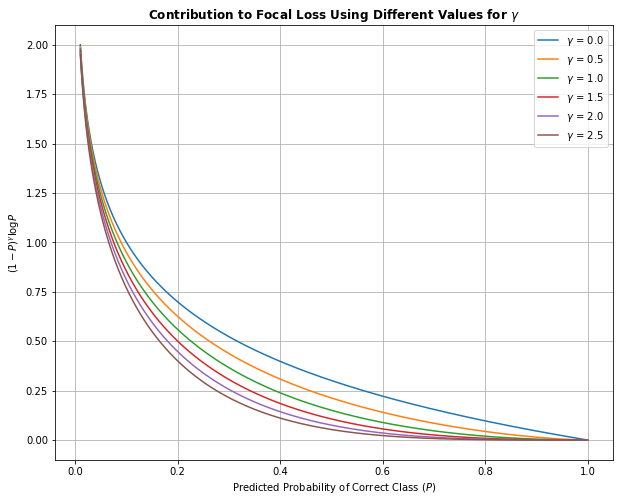

In [64]:
plt.figure(figsize=(10,8))
p = np.linspace(0.01, 1, 1000)
gammas = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5]
for gamma in gammas:
    plt.plot(p, ((1-p)**gamma)*-np.log10(p), label= '$\gamma$ = {}'.format(gamma))
plt.grid()
plt.legend()
plt.xlabel('Predicted Probability of Correct Class ($P$)')
plt.ylabel('$(1-P)^\gamma \log P$')
plt.title('Contribution to Focal Loss Using Different Values for $\gamma$', fontweight='bold');

First of all, note that blue curve in the figure above (when $\gamma$ = 0) represents simply the categorical crossentropy. However, as gamma increases notice that the contribution to the loss function becomes "sqauashed" for the easier to predict cases (when $P$ > 0.6). This means that the harder to predict cases contribute a larger percentage to the loss function compared to what they would normally. Unfortunately, ```keras``` does not yet support focal loss as an option for loss function, but we can use it as a custom loss function. The function ```categorical_focal_loss``` is defined below, and was copied from github user <a href='https://github.com/umbertogriffo/focal-loss-keras/blob/master/losses.py'>umbertogriffo.</a>

In [65]:
def categorical_focal_loss(gamma=2., alpha=.25):
    """
    Softmax version of focal loss.
           m
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1
      where m = number of classes, c = class and o = observation
    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy
      gamma -- focusing parameter for modulating factor (1-p)
    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """
        # Scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)
        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        # Sum the losses in mini_batch
        return K.sum(loss, axis=1)
    return categorical_focal_loss_fixed

The cell below fits the same neural network model created previously, but this time uses the  ```categorical_focal_loss()``` as the loss function. 

In [66]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df, num_hours=0, do_min_max_scaler = True)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
model.compile(optimizer=adam, loss=[categorical_focal_loss(gamma=2.0, alpha=0.25)], metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, verbose=True)

Train on 55272 samples, validate on 23689 samples
Epoch 1/10
55272/55272 [==============================] - 5s 85us/step - loss: 0.0198 - acc: 0.8787 - val_loss: 0.0198 - val_acc: 0.8829
Epoch 2/10
55272/55272 [==============================] - 4s 77us/step - loss: 0.0178 - acc: 0.8873 - val_loss: 0.0272 - val_acc: 0.8795
Epoch 3/10
55272/55272 [==============================] - 4s 71us/step - loss: 0.0176 - acc: 0.8875 - val_loss: 0.0192 - val_acc: 0.8876
Epoch 4/10
55272/55272 [==============================] - 4s 73us/step - loss: 0.0175 - acc: 0.8873 - val_loss: 0.0192 - val_acc: 0.8847
Epoch 5/10
55272/55272 [==============================] - 4s 77us/step - loss: 0.0172 - acc: 0.8891 - val_loss: 0.0196 - val_acc: 0.8821
Epoch 6/10
55272/55272 [==============================] - 4s 73us/step - loss: 0.0171 - acc: 0.8890 - val_loss: 0.0227 - val_acc: 0.8793
Epoch 7/10
55272/55272 [==============================] - 4s 74us/step - loss: 0.0172 - acc: 0.8881 - val_loss: 0.0191 - val_acc

Now that the model has been fitted, we can see how it performs on the test set:

In [67]:
predictions = model.predict(X_test)
give_metrics(y_test, np.argmax(predictions, axis=1), 3)

Performance Metrics: 

Confusion Matrix:
[[7020  321   26]
 [ 581  544   13]
 [  51    2   51]]


Class 0:
Recall:  0.9528980589113615
Precision:  0.9174072138003136
F1 Score: 0.9348158998601771


Class 1:
Recall:  0.4780316344463972
Precision:  0.6274509803921569
F1 Score: 0.542643391521197


Class 2:
Recall:  0.49038461538461536
Precision:  0.5666666666666667
F1 Score: 0.5257731958762886


Overall Metrics:
Total Accuracy:  0.8845394354745034
Average Recall (Macro):  0.6404381029141247
Average Precision (Macro) : 0.703841620286379
Average F1 Score (Macro):  0.6706446348458072


The printout above seems to indicate that this option will act as the best methodology moving forward. While the average precision exhibits a slight decrease from the class weighted model, the average recall has recovered greatly resulting in a higher average $F_1$ score.

#### 4.2.4: Summary of Different Options
The table below gives a summary of how the performance seen by implementing the three options evaluated above. Once again, each option was tested using a neural network with the same structure and initial parameters.
<table style="width:75%">
  <tr>
    <th>Metric</th>
    <th>Option 1 - SMOTE</th> 
    <th>Option 2 - Class Weights</th>
    <th>Option 3 - Focal Loss</th>  
  </tr>
  <tr>
    <td>Total Accuracy</td>
    <td>0.83</td>
    <td>0.89</td>
    <td>0.88</td>
  </tr>
  <tr>
    <td>Average Recall (Macro)</td>
    <td>0.83</td>
    <td>0.58</td>
    <td>0.64</td>
  </tr>
  <tr>
    <td>Average Precision (Macro)</td>
    <td>0.57</td>
    <td>0.73</td>
    <td>0.70</td>
  </tr>
    <tr>
    <td>Average $F_1$ Score (Macro)</td>
    <td>0.68</td>
    <td>0.65</td>
    <td>0.67</td>
  </tr>
</table>

Looking at each option, they each have their pros and cons. However, option 3 seems to have the best balance of precision and recall, and will thus be the choice moving forward. It should be noted that decent results could probably be achieved using any one of the above options. 

### 4.3: How Time to Prediction Affects Neural Network Performance
Before finally tuning the neural networks in order to make the most accurate predictions, the code in the cell below analyzes how the neural network performance changes for data with different values of <b>num_hours</b>. In other words, it checks to see how performance changes as the predictions are made farther into the future. It does this by fitting a neural network for each subset of data with the same value of <b>num_hours</b>, and then returning its training and validation set accuracy, along with the final loss value. 

In [68]:
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(16, )))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(3, activation='softmax'))
adam = keras.optimizers.Adam(0.001)
model.compile(optimizer=adam, loss=[categorical_focal_loss(gamma=2.0, alpha=0.25)], metrics=['accuracy'])

tmp = []
for i in range(13):
    # Data Preparation Steps Hidden by prepare_data()
    #subset = df[df['num_hours']==i]
    #X = subset.drop(columns=cols_to_drop)
    #y = subset['class'].values
    #X_test = df_test[df_test['num_hours']==0].drop(columns=cols_to_drop).values
    #y_test = df_test[df_test['num_hours']==0]['class'].values
    #X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
    #scaler = MinMaxScaler(feature_range=(0,1))
    #X_train = scaler.fit_transform(X_train)
    #X_val = scaler.transform(X_val)
    #X_test = scaler.transform(X_test)
    
    X_train, X_val, X_test, y_train, y_val, y_test = \
    prepare_data(df, num_hours=i, do_min_max_scaler = True)
    y_train = to_categorical(y_train)
    y_val = to_categorical(y_val)
    
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, verbose=False);
    
    train_loss = model.evaluate(X_train, y_train)[0]
    train_cat_acc = model.evaluate(X_train, y_train)[1]
    
    val_loss = model.evaluate(X_val, y_val)[0]
    val_cat_acc = model.evaluate(X_val, y_val)[1]
    
    tmp.append([i, train_loss, train_cat_acc, val_loss, val_cat_acc])

NN_model_performances = pd.DataFrame(tmp)
NN_model_performances.columns = ['num_hours', 'train_loss', 'train_cat_acc', 'val_loss', 'val_cat_acc']

23668/23668 [==============================] - 1s 27us/step


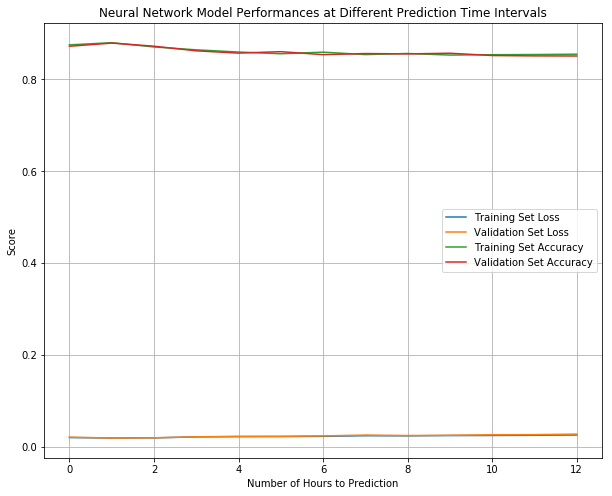

In [69]:
plt.figure(figsize = (10, 8))
plt.plot(NN_model_performances.num_hours, NN_model_performances.train_loss, label='Training Set Loss')
plt.plot(NN_model_performances.num_hours, NN_model_performances.val_loss, label='Validation Set Loss')
plt.plot(NN_model_performances.num_hours, NN_model_performances.train_cat_acc, label='Training Set Accuracy')
plt.plot(NN_model_performances.num_hours, NN_model_performances.val_cat_acc, label='Validation Set Accuracy')
plt.grid()
plt.legend(loc='center right')
plt.xlabel('Number of Hours to Prediction')
plt.ylabel('Score')

plt.title('Neural Network Model Performances at Different Prediction Time Intervals');

The results above are quite promising, and indicate that neural networks perform almost equally as well for different values of <b>num_hours</b>. There is still a slight overall decrease in accuracy and slight overall increase in loss, but they are dwarfed in comparison to the results that were apparent using the ```KNeighborsClassifier```. This bodes well for the case that neural networks are a great choice in attempting to solve this problem, and that they are capable of creating models that are complex enough to offer quality results even for predicitons 12 hours into the future. 

### 4.4: Fine Tuning the Neural Networks
Finally, this section does the work tuning the neural networks to figure out which structure, among other initial parameters, are the best choice for making predictions. Multiple different neural networks are created and tested for each subset of the dataset corresponding to different values of <b>num_hours</b>. More specifically, nine different nerual networks are created using combinations of 1, 2, or 3 hidden layers each with 50, 100, or 200 nodes. In addition, an ```EarlyStoppingMonitor``` is invoked in order to determine the optimal number of epochs that it will take to sufficiently train the network. 

<b>*CAUTION*</b>: Be wary of running the cell below. It creates, fits, and evaluates the performance of 9 * 13 = 117 neural networks. As is expected, this takes a very long time.

In [70]:
num_hidden_layer_options = [1, 2, 3]
num_nodes_options = [50, 100, 200]
max_epochs = 50
patience = 3
num_inputs = 16
learning_rate = 0.001

tmp = []

for i in range(0, 13):
    # Data Preparation Steps Hidden by prepare_data()
    #subset = df[df['num_hours']==i]
    #X = subset.drop(columns=cols_to_drop)
    #y = subset['class'].values
    #X_test = df_test[df_test['num_hours']==0].drop(columns=cols_to_drop).values
    #y_test = df_test[df_test['num_hours']==0]['class'].values
    #X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
    #scaler = MinMaxScaler(feature_range=(0,1))
    #X_train = scaler.fit_transform(X_train)
    #X_val = scaler.transform(X_val)
    #X_test = scaler.transform(X_test)
    
    X_train, X_val, X_test, y_train, y_val, y_test = \
    prepare_data(df, num_hours=i, do_min_max_scaler = True)
    y_train = to_categorical(y_train)
    y_val = to_categorical(y_val)
    

    for num_nodes in num_nodes_options:
    
        for j in range(len(num_hidden_layer_options)):
            model = Sequential()
            model.add(Dense(num_nodes, activation='relu', input_shape=(num_inputs, )))  
            
            for k in range(num_hidden_layer_options[j]-1):
                model.add(Dense(num_nodes, activation='relu'))
        
            model.add(Dense(3, activation='softmax'))
            adam = keras.optimizers.Adam(learning_rate)
            model.compile(optimizer=adam, loss=[categorical_focal_loss(gamma=2.0, alpha=0.25)], \
                          metrics=['accuracy'])
            early_stopping_monitor = EarlyStopping(patience=patience)
            model_hist = model.fit(X_train, y_train, epochs=max_epochs, validation_data = (X_val, y_val),\
                                   class_weight=class_weights, callbacks=[early_stopping_monitor], verbose=0)
        
            epochs = early_stopping_monitor.stopped_epoch
        
            loss = model_hist.history['loss'][-1]
            val_loss = model_hist.history['val_loss'][-1]
        
            acc = model_hist.history['acc'][-1]
            val_acc = model_hist.history['val_acc'][-1]
            predictions = model.predict(X_test)
            test_acc, test_R_avg, test_P_avg, test_F1_avg = \
            give_metrics(y_test, np.argmax(predictions, axis=1), 3, True) 
            
         
            tmp.append([i, num_nodes, num_hidden_layer_options[j], epochs, loss, val_loss, acc, \
                        val_acc, test_acc, test_R_avg, test_P_avg, test_F1_avg])
        

NN_model_tuning = pd.DataFrame(tmp)
NN_model_tuning.columns = ['num_hours', 'num_nodes', 'num_hidden_layers', 'epochs', 'loss', 'val_loss', 'acc', \
                           'val_acc', 'test_acc', 'test_recall_avg', 'test_precision_avg', 'test_F1_avg']

/anaconda3/envs/datatools/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/envs/datatools/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/envs/datatools/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/envs/datatools/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/envs/datatools/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/envs/datatools/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide


In [71]:
NN_model_tuning

,num_hours,num_nodes,num_hidden_layers,epochs,loss,val_loss,acc,val_acc,test_acc,test_recall_avg,test_precision_avg,test_F1_avg
0,0,50,1,16,0.019843,0.020522,0.879921,0.877243,0.877105,0.490241,0.703566,0.577844
1,0,50,2,16,0.018382,0.019108,0.885674,0.885432,0.880358,0.617510,0.685263,0.649625
2,0,50,3,11,0.018969,0.019642,0.882454,0.882224,0.881984,0.598006,0.653508,0.624526
3,0,100,1,22,0.018578,0.019284,0.884119,0.883744,0.878732,0.622325,0.673007,0.646674
4,0,100,2,6,0.019225,0.020220,0.881079,0.882857,0.879080,0.558648,0.706706,0.624015
5,0,100,3,13,0.018468,0.020213,0.883901,0.875216,0.875479,0.446607,0.775500,0.566798
6,0,200,1,16,0.018703,0.020048,0.883648,0.881802,0.876873,0.561290,0.693709,0.620514
7,0,200,2,6,0.019109,0.022053,0.882002,0.862215,0.865490,0.411468,0.795847,0.542469
8,0,200,3,6,0.019397,0.022292,0.880410,0.873528,0.869323,0.611264,0.597054,0.604075
9,1,50,1,13,0.020736,0.020415,0.876292,0.874937,0.870517,0.573326,0.693708,0.627798


The ```NN_model_tuning``` dataframe shown above holds the values of various metrics of performance for each neural network for every subset of data with different values of <b>num_hours</b>. The code in the cell below determines the best model for each value of <b>num_hours</b> by using the test set average $F_1$ score as the deciding measurement. It stores these models in the dataframe, ```best_NN_models```.

In [72]:
tmp = []
for i in range(0, 13):
    subset = NN_model_tuning[NN_model_tuning['num_hours']==i]
    tmp.append(subset.loc[subset['test_F1_avg'].idxmax()])
best_NN_models = pd.DataFrame(tmp)
best_NN_models = best_NN_models.reset_index(drop=True)
best_NN_models

,num_hours,num_nodes,num_hidden_layers,epochs,loss,val_loss,acc,val_acc,test_acc,test_recall_avg,test_precision_avg,test_F1_avg
0,0.0,50.0,2.0,16.0,0.018382,0.019108,0.885674,0.885432,0.880358,0.617510,0.685263,0.649625
1,1.0,100.0,1.0,12.0,0.020362,0.020795,0.877127,0.875106,0.870404,0.702271,0.650360,0.675319
2,2.0,50.0,3.0,8.0,0.021177,0.021493,0.866686,0.866878,0.864518,0.655662,0.614400,0.634361
3,3.0,50.0,2.0,8.0,0.022539,0.022477,0.860498,0.857294,0.863470,0.621188,0.634935,0.627986
4,4.0,50.0,2.0,20.0,0.022492,0.023027,0.861208,0.856509,0.857094,0.521948,0.645925,0.577356
5,5.0,100.0,1.0,19.0,0.024087,0.024141,0.853808,0.852201,0.845354,0.512018,0.635269,0.567023
6,6.0,200.0,2.0,11.0,0.024512,0.024993,0.856785,0.850994,0.845886,0.445547,0.617370,0.517570
7,7.0,100.0,2.0,18.0,0.024536,0.025948,0.854012,0.850237,0.846751,0.453098,0.632071,0.527826
8,8.0,200.0,3.0,13.0,0.025650,0.025419,0.852631,0.854462,0.847198,0.425220,0.642916,0.511884
9,9.0,100.0,2.0,9.0,0.026635,0.026520,0.850073,0.853306,0.849128,0.390836,0.675394,0.495143


The cell below shows the performances of the best models that are stored in ```best_NN_models``` by graphing their various metrics as a function of <b>num_hours</b>.

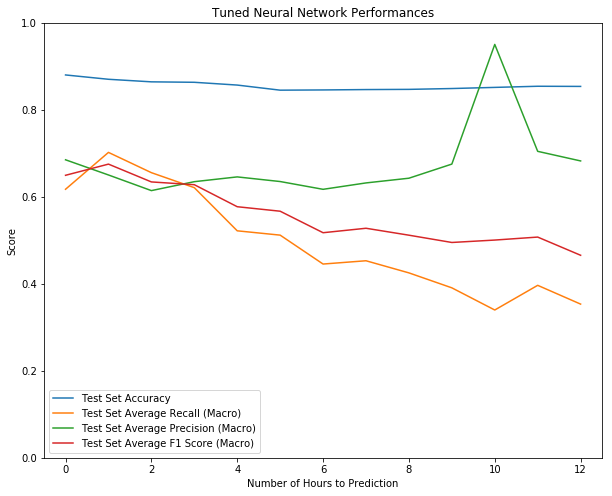

In [73]:
plt.figure(figsize=(10,8))
plt.plot(best_NN_models.num_hours, best_NN_models.test_acc, label='Test Set Accuracy')
plt.plot(best_NN_models.num_hours, best_NN_models.test_recall_avg, label='Test Set Average Recall (Macro)')
plt.plot(best_NN_models.num_hours, best_NN_models.test_precision_avg, label='Test Set Average Precision (Macro)')
plt.plot(best_NN_models.num_hours, best_NN_models.test_F1_avg, label='Test Set Average F1 Score (Macro)')
plt.title('Tuned Neural Network Performances')
plt.ylabel('Score')
plt.xlabel('Number of Hours to Prediction')
plt.axis([-0.5, 12.5, 0,1])
plt.legend()
plt.show()

### 4.5: Building a System of Neural Networks to Make Predictions
Now that we have determined the best neural network structures for each hour of prediction, they can finally be built! The cells below create the finely tuned models to make predictions for 0, 1, 2, ..., 12 hours into the future. 

In [74]:
best_model_structures = best_NN_models[['num_hours', 'num_nodes', 'num_hidden_layers', 'epochs']].astype(int)
best_model_structures

,num_hours,num_nodes,num_hidden_layers,epochs
0,0,50,2,16
1,1,100,1,12
2,2,50,3,8
3,3,50,2,8
4,4,50,2,20
5,5,100,1,19
6,6,200,2,11
7,7,100,2,18
8,8,200,3,13
9,9,100,2,9


In [75]:
i = 0
num_hours = best_model_structures.iloc[i][0]
num_nodes = best_model_structures.iloc[i][1]
epochs = best_model_structures.iloc[i][3]
learning_rate = 0.001

subset = df[df['num_hours']==num_hours]
y = subset['class'].values.reshape(-1, )
X = subset.drop(columns=cols_to_drop)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
X_scaler_0hr = MinMaxScaler(feature_range=(0,1))
X_train = X_scaler_0hr.fit_transform(X_train)
X_val = X_scaler_0hr.transform(X_val)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

model_0hr = Sequential()
model_0hr.add(Dense(num_nodes, activation='relu', input_shape=(num_inputs, )))
for j in range(1, best_model_structures.iloc[i][2]):
    model_0hr.add(Dense(num_nodes, activation='relu'))
model_0hr.add(Dense(3, activation='softmax'))
adam = keras.optimizers.Adam(learning_rate)
model_0hr.compile(optimizer=adam, loss=[categorical_focal_loss(gamma=2.0, alpha=0.25)])
model_0hr.fit(X_train, y_train, epochs=epochs, validation_data = (X_val, y_val), verbose=0)

In [76]:
i = 1
num_hours = best_model_structures.iloc[i][0]
num_nodes = best_model_structures.iloc[i][1]
epochs = best_model_structures.iloc[i][3]
learning_rate = 0.001

subset = df[df['num_hours']==num_hours]
y = subset['class'].values.reshape(-1, )
X = subset.drop(columns=cols_to_drop)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
X_scaler_1hr = MinMaxScaler(feature_range=(0,1))
X_train = X_scaler_1hr.fit_transform(X_train)
X_val = X_scaler_1hr.transform(X_val)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)


model_1hr = Sequential()
model_1hr.add(Dense(num_nodes, activation='relu', input_shape=(num_inputs, )))
for j in range(1, best_model_structures.iloc[i][2]):
    model_1hr.add(Dense(num_nodes, activation='relu'))
model_1hr.add(Dense(3, activation='softmax'))
adam = keras.optimizers.Adam(learning_rate)
model_1hr.compile(optimizer=adam, loss=[categorical_focal_loss(gamma=2.0, alpha=0.25)])
model_1hr.fit(X_train, y_train, epochs=epochs, validation_data = (X_val, y_val), verbose=0)

In [77]:
i = 2
num_hours = best_model_structures.iloc[i][0]
num_nodes = best_model_structures.iloc[i][1]
epochs = best_model_structures.iloc[i][3]
learning_rate = 0.001

subset = df[df['num_hours']==num_hours]
y = subset['class'].values.reshape(-1, )
X = subset.drop(columns=cols_to_drop)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
X_scaler_2hr = MinMaxScaler(feature_range=(0,1))
X_train = X_scaler_2hr.fit_transform(X_train)
X_val = X_scaler_2hr.transform(X_val)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

model_2hr = Sequential()
model_2hr.add(Dense(num_nodes, activation='relu', input_shape=(num_inputs, )))
for j in range(1, best_model_structures.iloc[i][2]):
    model_2hr.add(Dense(num_nodes, activation='relu'))
model_2hr.add(Dense(3, activation='softmax'))
adam = keras.optimizers.Adam(learning_rate)
model_2hr.compile(optimizer=adam, loss=[categorical_focal_loss(gamma=2.0, alpha=0.25)])
model_2hr.fit(X_train, y_train, epochs=epochs, validation_data = (X_val, y_val), verbose=0)

In [78]:
i = 3
num_hours = best_model_structures.iloc[i][0]
num_nodes = best_model_structures.iloc[i][1]
epochs = best_model_structures.iloc[i][3]
learning_rate = 0.001

subset = df[df['num_hours']==num_hours]
y = subset['class'].values.reshape(-1, )
X = subset.drop(columns=cols_to_drop)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
X_scaler_3hr = MinMaxScaler(feature_range=(0,1))
X_train = X_scaler_3hr.fit_transform(X_train)
X_val = X_scaler_3hr.transform(X_val)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)


model_3hr = Sequential()
model_3hr.add(Dense(num_nodes, activation='relu', input_shape=(num_inputs, )))
for j in range(1, best_model_structures.iloc[i][2]):
    model_3hr.add(Dense(num_nodes, activation='relu'))
model_3hr.add(Dense(3, activation='softmax'))
adam = keras.optimizers.Adam(learning_rate)
model_3hr.compile(optimizer=adam, loss=[categorical_focal_loss(gamma=2.0, alpha=0.25)])
model_3hr.fit(X_train, y_train, epochs=max_epochs, validation_data = (X_val, y_val), verbose=0)

In [79]:
i = 4
num_hours = best_model_structures.iloc[i][0]
num_nodes = best_model_structures.iloc[i][1]
epochs = best_model_structures.iloc[i][3]
learning_rate = 0.001

subset = df[df['num_hours']==num_hours]
y = subset['class'].values.reshape(-1, )
X = subset.drop(columns=cols_to_drop)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
X_scaler_4hr = MinMaxScaler(feature_range=(0,1))
X_train = X_scaler_4hr.fit_transform(X_train)
X_val = X_scaler_4hr.transform(X_val)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)


model_4hr = Sequential()
model_4hr.add(Dense(num_nodes, activation='relu', input_shape=(num_inputs, )))
for j in range(1, best_model_structures.iloc[i][2]):
    model_4hr.add(Dense(num_nodes, activation='relu'))
model_4hr.add(Dense(3, activation='softmax'))
adam = keras.optimizers.Adam(learning_rate)
model_4hr.compile(optimizer=adam, loss=[categorical_focal_loss(gamma=2.0, alpha=0.25)])
model_4hr.fit(X_train, y_train, epochs=epochs, validation_data = (X_val, y_val), verbose=0)

In [80]:
i = 5
num_hours = best_model_structures.iloc[i][0]
num_nodes = best_model_structures.iloc[i][1]
epochs = best_model_structures.iloc[i][3]
learning_rate = 0.001

subset = df[df['num_hours']==num_hours]
y = subset['class'].values.reshape(-1, )
X = subset.drop(columns=cols_to_drop)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
X_scaler_5hr = MinMaxScaler(feature_range=(0,1))
X_train = X_scaler_5hr.fit_transform(X_train)
X_val = X_scaler_5hr.transform(X_val)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

model_5hr = Sequential()
model_5hr.add(Dense(num_nodes, activation='relu', input_shape=(num_inputs, )))
for j in range(1, best_model_structures.iloc[i][2]):
    model_5hr.add(Dense(num_nodes, activation='relu'))
model_5hr.add(Dense(3, activation='softmax'))
adam = keras.optimizers.Adam(learning_rate)
model_5hr.compile(optimizer=adam, loss=[categorical_focal_loss(gamma=2.0, alpha=0.25)])
model_5hr.fit(X_train, y_train, epochs=max_epochs, validation_data = (X_val, y_val), verbose=0)

In [81]:
i = 6
num_hours = best_model_structures.iloc[i][0]
num_nodes = best_model_structures.iloc[i][1]
epochs = best_model_structures.iloc[i][3]
learning_rate = 0.001

subset = df[df['num_hours']==num_hours]
y = subset['class'].values.reshape(-1, )
X = subset.drop(columns=cols_to_drop)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
X_scaler_6hr = MinMaxScaler(feature_range=(0,1))
X_train = X_scaler_6hr.fit_transform(X_train)
X_val = X_scaler_6hr.transform(X_val)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)


model_6hr = Sequential()
model_6hr.add(Dense(num_nodes, activation='relu', input_shape=(num_inputs, )))
for j in range(1, best_model_structures.iloc[i][2]):
    model_6hr.add(Dense(num_nodes, activation='relu'))
model_6hr.add(Dense(3, activation='softmax'))
adam = keras.optimizers.Adam(learning_rate)
model_6hr.compile(optimizer=adam, loss=[categorical_focal_loss(gamma=2.0, alpha=0.25)])
model_6hr.fit(X_train, y_train, epochs=epochs, validation_data = (X_val, y_val), verbose=0)

In [82]:
i = 7
num_hours = best_model_structures.iloc[i][0]
num_nodes = best_model_structures.iloc[i][1]
epochs = best_model_structures.iloc[i][3]
learning_rate = 0.001

subset = df[df['num_hours']==num_hours]
y = subset['class'].values.reshape(-1, )
X = subset.drop(columns=cols_to_drop)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
X_scaler_7hr = MinMaxScaler(feature_range=(0,1))
X_train = X_scaler_7hr.fit_transform(X_train)
X_val = X_scaler_7hr.transform(X_val)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

model_7hr = Sequential()
model_7hr.add(Dense(num_nodes, activation='relu', input_shape=(num_inputs, )))
for j in range(1, best_model_structures.iloc[i][2]):
    model_7hr.add(Dense(num_nodes, activation='relu'))
model_7hr.add(Dense(3, activation='softmax'))
adam = keras.optimizers.Adam(learning_rate)
model_7hr.compile(optimizer=adam, loss=[categorical_focal_loss(gamma=2.0, alpha=0.25)])
model_7hr.fit(X_train, y_train, epochs=epochs, validation_data = (X_val, y_val), verbose=0)

In [83]:
i = 8
num_hours = best_model_structures.iloc[i][0]
num_nodes = best_model_structures.iloc[i][1]
epochs = best_model_structures.iloc[i][3]
learning_rate = 0.001

subset = df[df['num_hours']==num_hours]
y = subset['class'].values.reshape(-1, )
X = subset.drop(columns=cols_to_drop)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
X_scaler_8hr = MinMaxScaler(feature_range=(0,1))
X_train = X_scaler_8hr.fit_transform(X_train)
X_val = X_scaler_8hr.transform(X_val)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

model_8hr = Sequential()
model_8hr.add(Dense(num_nodes, activation='relu', input_shape=(num_inputs, )))
for j in range(1, best_model_structures.iloc[i][2]):
    model_8hr.add(Dense(num_nodes, activation='relu'))
model_8hr.add(Dense(3, activation='softmax'))
adam = keras.optimizers.Adam(learning_rate)
model_8hr.compile(optimizer=adam, loss=[categorical_focal_loss(gamma=2.0, alpha=0.25)])
model_8hr.fit(X_train, y_train, epochs=epochs, validation_data = (X_val, y_val), verbose=0)

In [84]:
i = 9
num_hours = best_model_structures.iloc[i][0]
num_nodes = best_model_structures.iloc[i][1]
epochs = best_model_structures.iloc[i][3]
learning_rate = 0.001

subset = df[df['num_hours']==num_hours]
y = subset['class'].values.reshape(-1, )
X = subset.drop(columns=cols_to_drop)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
X_scaler_9hr = MinMaxScaler(feature_range=(0,1))
X_train = X_scaler_9hr.fit_transform(X_train)
X_val = X_scaler_9hr.transform(X_val)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

model_9hr = Sequential()
model_9hr.add(Dense(num_nodes, activation='relu', input_shape=(num_inputs, )))
for j in range(1, best_model_structures.iloc[i][2]):
    model_9hr.add(Dense(num_nodes, activation='relu'))
model_9hr.add(Dense(3, activation='softmax'))
adam = keras.optimizers.Adam(learning_rate)
model_9hr.compile(optimizer=adam, loss=[categorical_focal_loss(gamma=2.0, alpha=0.25)])
model_9hr.fit(X_train, y_train, epochs=epochs, validation_data = (X_val, y_val), verbose=0)

In [85]:
i = 10
num_hours = best_model_structures.iloc[i][0]
num_nodes = best_model_structures.iloc[i][1]
epochs = best_model_structures.iloc[i][3]
learning_rate = 0.001

subset = df[df['num_hours']==num_hours]
y = subset['class'].values.reshape(-1, )
X = subset.drop(columns=cols_to_drop)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
X_scaler_10hr = MinMaxScaler(feature_range=(0,1))
X_train = X_scaler_10hr.fit_transform(X_train)
X_val = X_scaler_10hr.transform(X_val)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

model_10hr = Sequential()
model_10hr.add(Dense(num_nodes, activation='relu', input_shape=(num_inputs, )))
for j in range(1, best_model_structures.iloc[i][2]):
    model_10hr.add(Dense(num_nodes, activation='relu'))
model_10hr.add(Dense(3, activation='softmax'))
adam = keras.optimizers.Adam(learning_rate)
model_10hr.compile(optimizer=adam, loss=[categorical_focal_loss(gamma=2.0, alpha=0.25)])
model_10hr.fit(X_train, y_train, epochs=epochs, validation_data = (X_val, y_val), verbose=0)

In [86]:
i = 11
num_hours = best_model_structures.iloc[i][0]
num_nodes = best_model_structures.iloc[i][1]
epochs = best_model_structures.iloc[i][3]
learning_rate = 0.001

subset = df[df['num_hours']==num_hours]
y = subset['class'].values.reshape(-1, )
X = subset.drop(columns=cols_to_drop)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
X_scaler_11hr = MinMaxScaler(feature_range=(0,1))
X_train = X_scaler_11hr.fit_transform(X_train)
X_val = X_scaler_11hr.transform(X_val)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

model_11hr = Sequential()
model_11hr.add(Dense(num_nodes, activation='relu', input_shape=(num_inputs, )))
for j in range(1, best_model_structures.iloc[i][2]):
    model_11hr.add(Dense(num_nodes, activation='relu'))
model_11hr.add(Dense(3, activation='softmax'))
adam = keras.optimizers.Adam(learning_rate)
model_11hr.compile(optimizer=adam, loss=[categorical_focal_loss(gamma=2.0, alpha=0.25)])
model_11hr.fit(X_train, y_train, epochs=epochs, validation_data = (X_val, y_val), verbose=0)

In [87]:
i = 12
num_hours = best_model_structures.iloc[i][0]
num_nodes = best_model_structures.iloc[i][1]
epochs = best_model_structures.iloc[i][3]
learning_rate = 0.001

subset = df[df['num_hours']==num_hours]
y = subset['class'].values.reshape(-1, )
X = subset.drop(columns=cols_to_drop)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
X_scaler_12hr = MinMaxScaler(feature_range=(0,1))
X_train = X_scaler_12hr.fit_transform(X_train)
X_val = X_scaler_12hr.transform(X_val)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

model_12hr = Sequential()
model_12hr.add(Dense(num_nodes, activation='relu', input_shape=(num_inputs, )))
for j in range(1, best_model_structures.iloc[i][2]):
    model_12hr.add(Dense(num_nodes, activation='relu'))
model_12hr.add(Dense(3, activation='softmax'))
adam = keras.optimizers.Adam(learning_rate)
model_12hr.compile(optimizer=adam, loss=[categorical_focal_loss(gamma=2.0, alpha=0.25)])
model_12hr.fit(X_train, y_train, epochs=epochs, validation_data = (X_val, y_val), verbose=0)

We're done! The culmination of this is the creation of 13 neural networks that can make predictions as to whether it will be clear, rainy, or snowy from 0 to 12 hours into the future. The function ```make_weather_prediction()``` uses these neural networks (along with their ```MinMaxScalers```) to make predictions for a random set of atmospheric measurements. An example of this is done below:

In [88]:
temperature = 65.00
humidity = 60.
mslp = 1021.1
total_cloud_cover = 60.
high_cloud_cover = 30.
medium_cloud_cover = 51.
low_cloud_cover = 100.
sunshine_duration = 0.0
shortwave_radiation = 0.0
wind_speed_10m = 12.48
wind_dir_10m = 343.89
wind_speed_80m = 11.12
wind_dir_80m = 344.85
wind_speed_900mb = 0.45
wind_dir_900mb = 90.0
wind_gust = 11.42

sample_prediction = np.array([temperature, humidity, mslp, total_cloud_cover, high_cloud_cover, \
                             medium_cloud_cover, low_cloud_cover, sunshine_duration, \
                             shortwave_radiation, wind_speed_10m, wind_dir_10m, wind_speed_80m, \
                             wind_dir_80m, wind_speed_900mb, wind_dir_900mb, wind_gust]).reshape(1, 16)
make_weather_prediction(sample_prediction)

0     Clear
1     Clear
2     Clear
3     Clear
4     Clear
5     Clear
6     Clear
7     Clear
8     Clear
9     Clear
10    Clear
11    Clear
12    Clear
Name: predictions, dtype: object

Looks like clear weather, no need for an umbrella!

## Section 5: Conclusion and Next Steps

The end result of this project (the function, ```make_weather_prediction()```) allows us to predict the weather in Basel, Switerland anywhere from 0-12 hours into the future using a total of 13 finely tuned neural networks. In order to get there, various other machine learning algoriths and methodologies were implemented in order to learn about the data and how we could maximize performance and efficiency. The most difficult part of the project by far was figuring out how to get the predictive models to know when it was going to rain or snow, given that the precision and recall for predicting these classes never reached levels much above 0.7. However, the overall quality of the predictions that these nerual networks generate indicate that this could be a viable method of weather prediction in the near future, and could be a solution to the chaotic nature of weather patterns explained in the inroduction to this project. While the observed results are satisfying, there are future steps that can be taken to improve upon the work done to achieve it. A few of these are listed below:
<ul>
    <li>Attempting to predict rainfall and snowfall levels, as opposed to just whether or not it will rain or snow.</li>
    <li>Expanding the reach of the neural networks by using weather data from different locations. How would the structures and performance of the neural networks change when using data from different places? </li>
</ul>
Completing these steps would help to more holistically determine if using neural networks is a truely viable way to make weather predictions.